# Download and explore GTEx datasets.
Namely, the eQTL datasets (one file per tissue)  and the gene median TPM dataset.  
Data Source link: https://gtexportal.org/home/datasets

In [16]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from collections import Counter
#import hashlib
from IPython.display import Image
#import base64
from umls_utils import get_paths, CUIbase64
from cmapPy.pandasGEXpress.parse_gct import parse


pd.set_option('display.max_columns', None)

In [2]:
!jupyter nbconvert --to script GTEx-Copy1.ipynb
!sed -i '' '/.head(/d' GTEx-Copy1.py
!sed -i '' '/^#/d' GTEx-Copy1.py
!sed -i '' '/get_ipython()/d' GTEx-Copy1.py
!sed -i '' '/print/d' GTEx-Copy1.py

[NbConvertApp] Converting notebook GTEx-Copy1.ipynb to script
[NbConvertApp] Writing 67751 bytes to GTEx-Copy1.py


In [17]:
# Get paths from config file
config_path = '/Users/stearb/Dropbox/CHOP/R03/code/neo4j_build_CFDIKG/build_scripts/'
data_dir,helper_data_dir,output_dir,LOCAL_CPU,umls_dir,umls_out_dir = get_paths(config_path)

if not  os.path.isdir(output_dir+'GTEx'):
    os.mkdir(output_dir+'GTEx')
    print('Creating GTEx directory...')

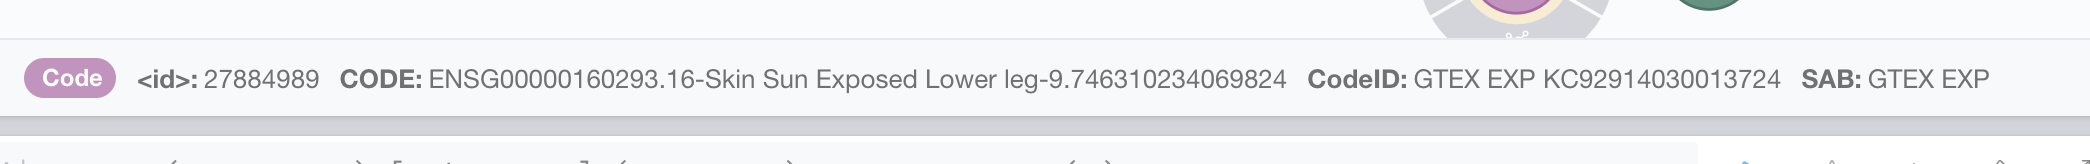

In [3]:
Image(filename='/Users/stearb/Desktop/R03_screenshots/gtex_tpm_props.png',width=900)

## Modeling Notes/Questions 
Median Expression 
* Median Expression Code nodes have Interval nodes as Terms. Each Interval Term node is connected to many Median Expression Code Nodes, is this allowed? (Code nodes sharing Term nodes)
* Median Expression Code nodes CodeID and CODE (see abover)

eQTL
* Currently using HGNC/UBERON/dbSNP Concept nodes to uniquely identify every eQTL 
* Instead,use the variant_id to link the eqtl node (with variant_id) to UBERON/HGNC nodes



* Concepts can link to multiple Codes from different ontologies
    * Ex) CUI C1416553 links to HGNC and OMIM

###  First, Get the Sample Annotations, which contain sample and uberon to tissue mappings (GTEx--UBERON mappings).
Data Source: https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt

In [21]:
#!curl --insecure https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt > gtex_sample_annotations.txt


samp_annos = pd.read_csv(helper_data_dir+'gtex_sample_annotations.txt',sep='\t')


print(samp_annos.shape)
samp_annos.head(8)

(22951, 63)


,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
0,GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,LCSET-4574,01/15/2014,Standard Exome Sequencing v3 (ICE),WES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,GTEx_OM25_Dec_01,01/28/2014,Illumina OMNI SNP Array,OMNI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,LCSET-6056,09/20/2014,PCR+ 30x Coverage WGS v2 (HiSeqX),WGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GTEX-1117F-0011-R10a-SM-AHZ7F,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,NaN,NaN,NaN,NaN,NaN,ChIP-Seq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GTEX-1117F-0011-R10b-SM-CYKQ8,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,BP-42319,RNA isolation_PAXgene Tissue miRNA,08/14/2013,NaN,NaN,RIP-Seq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,BP-43693,RNA Extraction from Paxgene-derived Lysate Pla...,09/17/2013,LCSET-4804,03/05/2014,TruSeq.v1,RNASEQ,NaN,0.986026,345562.0,0.966793,NaN,0.990383,0.756726,NaN,23548.0,1.0,NaN,76.0,NaN,0.002403,136.0,0.0,66833200.0,0.032919,209558.0,67482200.0,8797660.0,NaN,23575.0,33158000.0,NaN,NaN,0.0,0.210067,0.990383,0.749449,66833200.0,0.003919,14462700.0,8914900.0,14575600.0,144.0,14648800.0,11999300.0,0.003158,14669500.0,50.0354,0.003105,0.994740,NaN,0.0,50.1944
6,GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,BP-43495,RNA Extraction from Paxgene-derived Lysate Pla...,09/12/2013,LCSET-4764,02/09/2014,TruSeq.v1,RNASEQ,NaN,0.985786,145441.0,0.978816,NaN,0.990413,0.838961,NaN,20246.0,1.0,NaN,76.0,NaN,0.002413,137.0,0.0,59963600.0,0.020952,423484.0,60544100.0,9601460.0,NaN,20259.0,29785800.0,NaN,NaN,0.0,0.139855,0.990413,0.830918,59963600.0,0.005538,13154500.0,8383440.0,13125800.0,139.0,13191500.0,11550200.0,0.003968,13340500.0,50.2809,0.006995,0.995041,NaN,0.0,49.9455
7,GTEX-1117F-0526-SM-5EGHJ,0.0,B1,"2 pieces, clean, Monckebeg medial sclerosis, r...",8.0,Blood Vessel,Artery - Tibial,0007610,1221.0,1120.0,BP-43495,RNA Extraction from Paxgene-derived Lysate Pla...,09/12/2013,LCSET-4764,02/09/2014,TruSeq.v1,RNASEQ,NaN,0.983859,223040.0,0.971360,NaN,0.988930,0.767837,NaN,22193.0,1.0,NaN,76.0,NaN,0.002631,126.0,0.0,59839400.0,0.028310,173556

In [5]:
# Select the 3 columns  we need from the annotation dataset     # dont actually need sample id
# SMTS = Tissue
# SMTSD = More specific Tissue
# SMUBRID = UBERON ID
SAMPID_2_TISSUE = samp_annos[['SMTS','SMTSD','SMUBRID']] # 'SAMPID',

# Remove dashes, -, and parentheses so the tissue strings match the tissue strings from the eqtl datasets.
SAMPID_2_TISSUE['SMTSD'] = SAMPID_2_TISSUE['SMTSD'].str.replace(' - ',' ').str.replace('\(','').str.replace('\)','')

# Get only unique tissue IDs for mapping tissues--UBERON codes later.
SAMPID_2_TISSUE_unique = SAMPID_2_TISSUE.drop_duplicates('SMTSD')  # .drop('SAMPID',axis=1)
SAMPID_2_TISSUE_unique.rename(columns={'SMTSD':'tissue'},inplace=True)

print(SAMPID_2_TISSUE.shape)
SAMPID_2_TISSUE.head()

(22951, 3)


,SMTS,SMTSD,SMUBRID
0,Blood,Whole Blood,0013756
1,Blood,Whole Blood,0013756
2,Blood,Whole Blood,0013756
3,Brain,Brain Frontal Cortex BA9,0009834
4,Brain,Brain Frontal Cortex BA9,0009834


In [6]:
SAMPID_2_TISSUE_unique[SAMPID_2_TISSUE_unique['SMTS'] == 'Heart']

,SMTS,tissue,SMUBRID
9,Heart,Heart Atrial Appendage,0006631
52,Heart,Heart Left Ventricle,0006566


In [7]:
# using, match (n:Code {SAB:'UBERON'})  return count(distinct n); 

# new FREEZE has 14140 distinct UBERON  code

# old UMLS has distinct only 11214 UBERON codes

#### Note: UBERON:0002037 maps to 2 different Tissue strings in this data.

In [8]:
# https://www.ebi.ac.uk/ols/ontologies/uberon/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FUBERON_0002037

SAMPID_2_TISSUE[SAMPID_2_TISSUE['SMUBRID'] == '0002037'].drop_duplicates()


,SMTS,SMTSD,SMUBRID
64,Brain,Brain Cerebellum,0002037
265,Brain,Brain Cerebellar Hemisphere,0002037


In [13]:
%%time
# GET CUI - HGNC CODE MAPPINGS STRAIGHT FROM CSVs
UMLS_CUI_CODEs = pd.read_pickle(umls_dir+'CUI-CODEs.pickle')

umls_genes = UMLS_CUI_CODEs[UMLS_CUI_CODEs[':END_ID'].str.startswith('HGNC')].rename(
                                    columns={':START_ID':'CUI_hgnc',':END_ID':'HGNC_ID'})

#umls_genes.reset_index(drop=True).to_pickle('HGNC_CUI_CODEs.pickle')

CPU times: user 5.75 s, sys: 417 ms, total: 6.17 s
Wall time: 6.17 s


###  Also, get the master list of HGNC IDs (that maps gene names to HGNC IDs)
Data Source: ftp://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/non_alt_loci_set.txt

In [14]:
#!curl ftp://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/non_alt_loci_set.txt > hgnc_master.txt
if LOCAL_CPU: hgnc_master = pd.read_csv('hgnc_master.txt',sep='\t')
else: hgnc_master =  pd.read_csv(helper_data_dir+'hgnc_master.txt',sep='\t')



In [12]:
%%capture


''' # NEED TO USE THE 'hgnc_master.txt' from the FTP site ^^^, it contains data we cant get from the graph,
UMLS_CODE_SUIs = pd.read_csv(umls_dir+'CODE-SUIs.csv')

# Filter for just the HGNC CodeID rows
umls_hgnc = UMLS_CODE_SUIs[UMLS_CODE_SUIs[':START_ID'].isin(umls_genes['HGNC_ID'])]

# Get just the rows that contain relationship type 'ACR', this is where the gene symbol/name is.
umls_hgnc_acr = umls_hgnc[umls_hgnc[':TYPE'] == 'ACR']

umls_hgnc_acr.rename(columns={':START_ID':'CodeID',':END_ID':'SUI:ID'},inplace=True) 

# Read in UMLS SUIs so we can map the name property (where the gene symbol/name is) to the HGNC CodeID, merge on SUI:ID
UMLS_SUIs = pd.read_csv(umls_dir+'SUIs.csv')

# Merge in the names of the HGNC IDs, merge on SUI:ID
hgnc_master = pd.merge(umls_hgnc_acr,UMLS_SUIs,on='SUI:ID')

# Get just the HGNC CODE, not CodeID
hgnc_master['hgnc_id'] = [i.split(' ')[1] for i in hgnc_master['CodeID']]

hgnc_master.rename(columns={'name':'symbol'},inplace=True) 

hgnc_master.head(3)'''

# Import eQTL data
File:  GTEx_Analysis_v8_eQTL/  
(Contains 48 tissue files)  

Look at  the original tar file and see  how many egene files are in there

In [11]:
if LOCAL_CPU: eqtl_path =  '/Users/stearb/desktop/R03_local/data/gtex/GTEx_Analysis_v8_eQTL/egenes/'
else: eqtl_path =  data_dir+'/egenes/'


# Identify columns of interest
eqtl_columns = ['gene_id','gene_name','gene_chr','pval_true_df',
                                 'variant_id','rs_id_dbSNP151_GRCh38p7']

#['gene_id','gene_name','gene_chr','gene_start','gene_end','pval_true_df','variant_id','rs_id_dbSNP151_GRCh38p7','maf']

# Create  empty eqtl dataframe with columns we want
eqtl = pd.DataFrame(columns=eqtl_columns)

# Create lists that will be put in a eqtl_stats df
tissue_eqtl_dict = {}

print('File ,\tTissue,\t# of eQTLs')

#  Main loop to read in every eqtl file (one per tissue), append a 'tissue' column and concat each dataframe.
for i,filename in enumerate(os.listdir(eqtl_path)):
    
    tissue = filename.split(".")[0].replace('_',' ') # get tissue name from filename
    
    df = pd.read_csv(eqtl_path+filename,'\t')[eqtl_columns] # import and select columns
    
    df['tissue'] = [tissue]*df.shape[0] # add tissue type to tissue col.
    
    print(i,tissue,df.shape[0])

    tissue_eqtl_dict[tissue] = df.shape[0]
    
    if i == 0: eqtl=df # initialize eqtl dataframe if its the
    else:  eqtl = eqtl.append(df)
    

# Create eqtl_stats dataframe for plotting only.
#pd.DataFrame([tissues,eqtl_per_tissue])
        

print('Total # of eQTLs: '+str(len(eqtl)))


File ,	Tissue,	# of eQTLs
0 Heart Atrial Appendage 23194
1 Brain Cerebellar Hemisphere 25144
2 Brain Hippocampus 24420
3 Esophagus Gastroesophageal Junction 24168
4 Brain Caudate basal ganglia 24718
5 Minor Salivary Gland 25579
6 Esophagus Mucosa 23949
7 Brain Cortex 24849
8 Brain Frontal Cortex BA9 24676
9 Skin Sun Exposed Lower leg 25196
10 Brain Cerebellum 25461
11 Muscle Skeletal 21031
12 Ovary 25325
13 Prostate 26529
14 Colon Transverse 25379
15 Small Intestine Terminal Ileum 26182
16 Adipose Visceral Omentum 24724
17 Pituitary 26854
18 Skin Not Sun Exposed Suprapubic 25279
19 Artery Coronary 24529
20 Kidney Cortex 24807
21 Brain Substantia nigra 24044
22 Lung 26095
23 Vagina 25778
24 Brain Spinal cord cervical c-1 24669
25 Testis 35007
26 Adipose Subcutaneous 24665
27 Brain Putamen basal ganglia 23804
28 Breast Mammary Tissue 25849
29 Thyroid 26054
30 Nerve Tibial 25873
31 Whole Blood 20315
32 Esophagus Muscularis 23871
33 Artery Aorta 23959
34 Stomach 24290
35 Adrenal Gland 2382

In [14]:
%%capture
'''
plt.figure(figsize=(8,12))

d = dict(sorted(tissue_eqtl_dict.items(), key=lambda item: item[1]))

plt.barh(range(len(d)), list(d.values()), align='center'); plt.grid(alpha=.4,axis='x')
#plt.gca().set_xscale('log')
plt.yticks(range(len(d)), list(d.keys())); plt.show()


plt.figure(figsize=(8,8))
c = dict(Counter(eqtl['gene_chr']).most_common())

plt.barh(range(len(c)), list(c.values())[::-1], align='center'); plt.grid(alpha=.4,axis='x')
plt.yticks(range(len(c)), list(c.keys())[::-1])
plt.title('eQTL counts by chromosome\nNo eQTLs from chromosome Y or MT?',size=15); plt.show()'''

In [15]:
# Save list of unique rsIDs to compare overlap with KidsFirst rsIDs later
#pd.DataFrame(eqtl['rs_id_dbSNP151_GRCh38p7'].unique()).to_csv(
#                                '/Users/stearb/Desktop/R03_local/data/gtex/gtex_rsIDs.csv',index=False)

In [1]:
# These 6 tissues are not present in the EQTL datafiles
#for i in SAMPID_2_TISSUE['SMTSD'].unique():
#    if i not in eqtl['tissue'].unique():
#        print(i)

### Merge in the tissue to UBERON code mappings and add SAB

In [13]:
# Merge the eqtl df with the df containing the tissue to UBERON code mappings.
eqtl_ub  = pd.merge(left=SAMPID_2_TISSUE_unique,
                                     right=eqtl,
                                     on='tissue',
                                     how='right')

assert eqtl_ub.shape == eqtl_ub.dropna().shape

eqtl_ub.rename(columns={'gene_name': 'symbol'},inplace=True)

eqtl_ub['SAB'] = 'GTEX_EQTL'

# Change chromosomes from 'chr#' to '#' (just the number)
eqtl_ub['gene_chr'] = eqtl_ub['gene_chr'].str.replace('chr','')


eqtl_ub.rename(columns={'SMUBRID':'UBERON_code'},inplace=True)

print(eqtl_ub.shape)
eqtl_ub.head(3)

(1207976, 10)


,SMTS,tissue,UBERON_code,gene_id,symbol,gene_chr,pval_true_df,variant_id,rs_id_dbSNP151_GRCh38p7,SAB
0,Heart,Heart Atrial Appendage,0006631,ENSG00000227232.5,WASH7P,1,0.000378,chr1_1011654_G_A_b38,rs2465126,GTEX_EQTL
1,Heart,Heart Atrial Appendage,0006631,ENSG00000268903.1,RP11-34P13.15,1,0.000645,chr1_1134748_T_G_b38,rs9442378,GTEX_EQTL
2,Heart,Heart Atrial Appendage,0006631,ENSG00000269981.1,RP11-34P13.16,1,0.000474,chr1_108826_G_C_b38,rs62642117,GTEX_EQTL


### Lets see the overlap between the eQTL genes and the HGNC genes

In [18]:
%%capture
'''
# Number of genes shared between hgnc master list and eQTL genes
print(len(hgnc_master['symbol'].unique()))
print(len(eqtl_ub['symbol'].unique()))
venn2([set(hgnc_master['symbol']),set(eqtl_ub['symbol'])],set_labels=('hgnc master list','eQTL genes'));plt.show()
'''

## Seperate eqtl_ub by hgnc and no_hgnc
Then Merge the eqtl_hgnc df with hgnc concept-code mappings, then add a np.nan column onto no_hgnc, and then concat the 2 df's back together in order to add UBERON concept-code mappings.

In [14]:
print(eqtl_ub.shape)

# eqtls with HGNC IDs
eqtl_HGNC  = eqtl_ub[eqtl_ub['symbol'].isin(hgnc_master['symbol'])]
print(eqtl_HGNC.shape)

# eqtls without HGNC IDs
eqtl_noHGNC  = eqtl_ub[~eqtl_ub['symbol'].isin(hgnc_master['symbol'])]
print(eqtl_noHGNC.shape)


(1207976, 10)
(917595, 10)
(290381, 10)


### Merge in the HGNC IDs on (gene) 'symbol' column for the eqtls that have them.

In [15]:
eqtl_HGNC_merged = pd.merge(left=hgnc_master[['symbol','hgnc_id']],
                         right=eqtl_HGNC,
                         on='symbol',
                         how='left').dropna()

# Make sure we didnt lose any rows.
assert eqtl_HGNC_merged.shape[0] == eqtl_HGNC.shape[0]

### Merge in the UMLS HGNC CUIs (we dont want to recreate them, they already exist in UMLS)

In [21]:
# from freeze-ish
#UMLS_CUI_CODEs = pd.read_csv('/Users/stearb/Desktop/hubmap-kg/FREEZE-ish/CUI-CODEs.csv')
#umls_genes = UMLS_CUI_CODEs[UMLS_CUI_CODEs[':END_ID'].str.startswith('HGNC')].rename(
#                                                    columns={':START_ID':'CUI_human',':END_ID':'hgnc_id'})
#umls_genes['hgnc_id'] = [i.split(' ')[1] for i in umls_genes['hgnc_id']]
#umls_genes.head(3)

In [22]:
%%capture
## We need to connect the gene nodes at the concept level and not at the code level. 
## we can just line up the 'HGNC' CUIs with the 'HCOP HGNC' CUIs.
# To do this we need the 'HGNC' CUIs from UMLS, with their corresponding 'HGNC' Code 
#(Because the HGNC CUIs have no information attached to them so we need to bring the HGNC code along with it to merge)

# OLD WAY OF GETTING THE HGNC_ID - CUI mappings, (by building the graph and then querying it. Now we just look at the UMLS CSV files) 
#  match (n:Code)--(m:Concept) where n.SAB = 'HGNC' return n.CODE as HGNC_CODE,m.CUI AS HGNC_CONCEPT 
# ...save as umls-genes-concepts-codes.csv

#if LOCAL_CPU:umls_genes  = pd.read_csv('/Users/stearb/desktop/R03_local/data/umls-genes-concepts-codes.csv')
#else: umls_genes2  = pd.read_csv(helper_data_dir+'umls-genes-concepts-codes.csv')
#umls_genes2.rename(columns={'Concept':'CUI_hgnc','Code':'hgnc_id'},inplace=True)
#umls_genes2.head(3)

'''
# NEW WAY: Get them straight from CSVs
UMLS_CUI_CODEs = pd.read_csv(umls_dir+'CUI-CODEs.csv')
umls_genes = UMLS_CUI_CODEs[UMLS_CUI_CODEs[':END_ID'].str.startswith('HGNC')].rename(
                                                    columns={':START_ID':'CUI_human',':END_ID':'hgnc_id'})
umls_genes['hgnc_id'] = [i.split(' ')[1] for i in umls_genes['hgnc_id']]
umls_genes.head(3)'''

In [16]:
# Reformat umls_genes a little bit.
umls_genes['hgnc_id'] = [i.split(' ')[1] for i in umls_genes['HGNC_ID']]
umls_genes.drop('HGNC_ID',axis=1,inplace=True)
umls_genes[['CUI_hgnc','hgnc_id']].rename(columns={'CUI_hgnc':'CUI_human'},inplace=True)

In [17]:
#  merge in UMLS HGNC code-concept mapping
eqtl_HGNC_merged_2 = pd.merge(left=umls_genes,right=eqtl_HGNC_merged,on='hgnc_id')#,how='outer')#,indicator=True)

# Make sure we didnt lose any rows.
#assert eqtl_HGNC_merged.shape[0] == eqtl_HGNC_merged_2.shape[0]

eqtl_HGNC_merged_2.head(2)

,CUI_hgnc,hgnc_id,symbol,SMTS,tissue,UBERON_code,gene_id,gene_chr,pval_true_df,variant_id,rs_id_dbSNP151_GRCh38p7,SAB
0,C0694879,HGNC:3513,EXT2,Heart,Heart Atrial Appendage,0006631,ENSG00000151348.13,11,0.000010,chr11_44095874_G_A_b38,rs12365753,GTEX_EQTL
1,C0694879,HGNC:3513,EXT2,Brain,Brain Cerebellar Hemisphere,0002037,ENSG00000151348.13,11,0.000003,chr11_44066439_G_T_b38,rs2074038,GTEX_EQTL


In [23]:
#Counter(eqtl_HGNC_merged_2['_merge'])

In [24]:
#eqtl_HGNC_merged_2.shape#[eqtl_HGNC_merged_2['_merge'] != 'both']

In [25]:
#eqtl_HGNC_merged[~eqtl_HGNC_merged.isin(eqtl_HGNC_merged_2)].dropna(how = 'all')

In [26]:
#eqtl_HGNC_merged.nunique()

#for i,r in eqtl_HGNC_merged.iterrows():
#    eqtl_HGNC_merged['new_col'][i] = r['symbol'] + ['hgnc']

In [27]:
#eqtl_HGNC_merged_2.nunique()

### Join both eqtl datasets (the one that has HGNC IDs and the one that didnt) back together.

In [18]:
# Add an 'hgnc_id' and a 'CUI_hgnc' column here so we can concat the two dfs  back together.
eqtl_noHGNC['hgnc_id'] = np.nan
eqtl_noHGNC['CUI_hgnc'] = np.nan

# Rejoin  
eqtl_all_GTEx = pd.concat([eqtl_HGNC_merged_2,eqtl_noHGNC])

eqtl_all_GTEx.head(3)

,CUI_hgnc,hgnc_id,symbol,SMTS,tissue,UBERON_code,gene_id,gene_chr,pval_true_df,variant_id,rs_id_dbSNP151_GRCh38p7,SAB
0,C0694879,HGNC:3513,EXT2,Heart,Heart Atrial Appendage,0006631,ENSG00000151348.13,11,0.000010,chr11_44095874_G_A_b38,rs12365753,GTEX_EQTL
1,C0694879,HGNC:3513,EXT2,Brain,Brain Cerebellar Hemisphere,0002037,ENSG00000151348.13,11,0.000003,chr11_44066439_G_T_b38,rs2074038,GTEX_EQTL
2,C0694879,HGNC:3513,EXT2,Brain,Brain Hippocampus,0001954,ENSG00000151348.13,11,0.000512,chr11_44177124_T_C_b38,rs75552889,GTEX_EQTL


## Merge in the UBERON Concepts (CUIs) to the df. 
#### To do this we need to get the UBERON Concept-Code mappings from UMLS, just like we did with the hgnc nodes

In [29]:
%%capture
#### OLD WAY TO GET UBERON CODE-CUI MAPPINGS
# NEO4j query:  match (n:Code)--(m:Concept) where n.SAB = 'UBERON' return n.CODE as UBERON_code, m.CUI as UBERON_CUI
# Saved as umls-uberon-code-concept.txt

# Must pass a datatype dict to make sure the leading zeros arent trimmed 
#(bc read_csv() reads in codes as ints and removes leading zeros)

#dtype_dic= { 'UBERON_code':str, 'UBERON_CUI':str}

#if LOCAL_CPU:umls_uberon  = pd.read_csv('/Users/stearb/desktop/R03_local/data/umls-uberon-code-concept.txt', dtype = dtype_dic)
#else:umls_uberon  = pd.read_csv(helper_data_dir+'umls-uberon-code-concept.txt', dtype = dtype_dic)


#### NEW WAY, STRAIGHT FROM CSVs. WE need to get the code-CUI mappings from the code-suis file, see below
'''
UMLS_CODEs = pd.read_csv(umls_dir+'CODEs.csv')
uberon_codes = UMLS_CODEs[UMLS_CODEs['CodeID:ID'].str.startswith('UBERON')]

UMLS_CUI_CODEs = pd.read_csv(umls_dir+'CUI-CODEs.csv')
UMLS_CUI_CODEs.rename(columns={':START_ID':'CUI',':END_ID':'CodeID:ID'},inplace=True)

UMLS_CUI_CODEs.head(3)

umls_uberon = pd.merge(uberon_codes,UMLS_CUI_CODEs,on='CodeID:ID').rename(
    columns={'CODE':'UBERON_code','CUI':'UBERON_CUI'}).drop(['CodeID:ID','SAB'],axis=1)

umls_uberon.head(3)'''

### In the updated freeze of UMLS from Jonathan there are multiple concepts for some UBERON codes. When there are 2 Concepts for a code, we want to pick the Concept that is ID'd on the PT (Preferred term) relationship b/t the UBERON code and the preferred term node.

In [19]:
UMLS_CODE_SUIs = pd.read_csv(umls_dir+'CODE-SUIs.csv')
UMLS_CODE_SUIs.rename(columns={':START_ID':'CODE',':END_ID':'SUI'},inplace=True)

# Filter for UBERON mappings only
UBERON_CODE_SUIs = UMLS_CODE_SUIs[UMLS_CODE_SUIs['CODE'].str.contains('UBERON')]

# Just want the mappings where the relationship = 'PT'
UBERON_CODE_SUIs_PT = UBERON_CODE_SUIs[UBERON_CODE_SUIs[':TYPE'] == 'PT']

# Split UBERON CODE column so it matches the df we want to merge with
UBERON_CODE_SUIs_PT['CODE'] = [i.split(' ')[1] for i in UBERON_CODE_SUIs_PT['CODE']]


# Rename cols and the actual df to replace the 'umls_uberon' mappings we originally had.
# These new ones contain 1:1 code-concept mappings
umls_uberon = UBERON_CODE_SUIs_PT[['CODE','CUI']].rename(
    columns={'CODE':'UBERON_code','CUI':'UBERON_CUI'})

In [20]:
#UBERON_CODE_SUIs_PT = UMLS_CODE_SUIs_PT[UMLS_CODE_SUIs_PT['CODE'].isin(umls_uberon['UBERON_code'])]

umls_uberon.nunique()

UBERON_code    14140
UBERON_CUI     14202
dtype: int64

In [21]:
## Filter out rows where the UBERON code has an 'EFO_' prefix (Experimental factor ontology).
eqtl_all_GTEx = eqtl_all_GTEx[~eqtl_all_GTEx['UBERON_code'].str.contains('EFO')]


In [48]:
%%capture
'''
print('# of unique UBERON codes from GTEx: ',end='')
print(len(set(eqtl_all_GTEx['UBERON_code'])))

print('Overlapping UBERON codes between UMLS and GTEx: ',end='')
print(len(set(eqtl_all_GTEx['UBERON_code']).intersection(set(umls_uberon['UBERON_code']))),end=', or ')

############################################################################
##### ALL UBERON CODES ARE NOW IN UMLS. Disregard the 3 lines below. #######
############################################################################

# GTEx UBERON Codes (and Tissues) not in UMLS (there are 31 of them.)
# These UBERON Codes represent tissues that were already represented in UMLS before UBERON was added, 
# hence, they already have a CUI from another ontology/vocab. (NCIT)
eqtl_all_GTEx[~eqtl_all_GTEx['UBERON_code'].isin(umls_uberon['UBERON_code'])][['UBERON_code',
                                                                               'tissue']].drop_duplicates().head(3)'''

In [49]:
%%capture
############################################################################
##### ALL UBERON CODES ARE NOW IN UMLS. Disregard this entire code block. #######
############################################################################

'''
# I went the the Ontology Lookup Service (OLS) and searched for each of these Tissues and got the UMLS CUI that way. 
# I also could have added these Tissue strings to a list, imported them and ran a cypher query 
# returning the corresponding CUIs...

# One of these CUIs we got from Ontology Lookup Service website is wrong, probably out of date and refering to 
# an old version of UMLS...

# old umls Concept CUI for anterior lingual gland was C0930558. It is now C0226951
new_alg_cui = 'C0226951' # umls CUI for NCIT code C32987

# Look up these UBERON codes and get their UMLS xref (CUIs) from https://www.ebi.ac.uk/ols/index
umls_ubxref  = pd.DataFrame([
    ['0007610','C0085427'],
    ['0001621','C0205042'],
    ['0000992','C0029939'],
    ['0000995','C0042149'],
    ['0000996', 'C0042232'],
    ['0002046','C0040132'],
    ['0001150','C0227582'],
    ['0004648','C0227177'],
    ['0004550','C0227192'],
    ['0000945','C0038351'],
    ['0001211','C0031272'],
    ['0001157','C0227386'],
    ['0002367','C0033572'],
    ['0000473','C0039597'],
    ['0001323','C0040186'],
    ['0001496','C0003956'],
    ['0006469','C0457851'],
    ['0006330',new_alg_cui],  # The UMLS CUI that corresponds to this  NCIT code (C32987), C0930558  isnt in UMLS FOR SOME REASON (anterior lingual gland)
    ['0002369','C0001625'],
    ['0008952','C1261076'],
    ['0002106','C0037993'],
    ['0006920','C1707950'],
    ['0000007','C0032005'],
    ['0001873','C0007461'],
    ['0001874','C0034169'],
    ['0001898','C0020663'],
    ['0001114','C0227481'],
    ['0001954','C0019564'],
    ['0001225','C0022655'],
    ['0001876','C0002708'],
    ['0001882', 'C0028633']  ],columns=['UBERON_code','UBERON_CUI'])

umls_ubxref.shape

# As expected, there are 31 UBERON codes we mapped to the eqtl data that were not in UMLS as UBERON codes
len(set(np.ravel(eqtl_all_GTEx[~eqtl_all_GTEx['UBERON_code'].isin(
                umls_uberon['UBERON_code'])][['UBERON_code']].drop_duplicates().values)
               ).intersection(set(umls_ubxref['UBERON_code'])))'''

In [22]:
##### Now we have the UBERON-CUI mappings for the UBERON codes that didnt have UBERON CUIs in UMLS. This is because 
##### there were already CUIs representing these tissues in UMLS before UBERON was added. 
##### (Most were from the NCI Thesaurus)

##### We need to add the mappings in umls_ubxref to the UBERON-CUIs mappings in umls_uberon .
#umls_uberon_xref = pd.concat([umls_uberon,umls_ubxref])


####### DONT NEED TO MANUALLY ADD IN THE XREFs BC ALL UBERON CODES ARE NOW IN UMLS
umls_uberon_xref = umls_uberon


#------
### Filter by the UMLS UBERON codes 
#eqtl_all_GTEx =eqtl_all_GTEx[eqtl_all_GTEx['UBERON_code'].isin(umls_uberon['UBERON_code'])]

#------
# There were Only 15 of the (unique) codes from our eqtl dataset are in the umls UBERON dataset.
# 31 are not, hence umls_xref has 31 codes.
# There are 46 total (unique) UBERON codes in the eqtl dataset.

### Do the actual Merging in of UBERON CUIs

In [23]:
eqtl_all_GTEx = pd.merge(left=eqtl_all_GTEx,right=umls_uberon_xref,on='UBERON_code')

assert eqtl_all_GTEx.shape[0] == eqtl_all_GTEx.shape[0]

### Remove rows that do not have an rs id
Some rows have '.'for their rs id. Will this mess the Term 'rs_id' hash up?  
Leave out  these 2219 for now. We can just use db_snp rs id if we dont include these 2200, instead  of needing to have the tissue attached.  


Drops 2219 rows

In [24]:
eqtl_all_GTEx = eqtl_all_GTEx[eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7'] != '.']

### NO LONGER DROPPING ROWS W/O HGNC_ID (just exclude them when creating the hgnc-gtex_eqtl CUI-CUI relationship). 
No longer doing this: (Removing rows that do not have an hgnc_id drops 276,181 rows.) 

In [53]:
# Save rows where hgnc_id = Nan
#eqtl_all_GTEx_noHGNC = eqtl_all_GTEx[eqtl_all_GTEx['hgnc_id'].isna()] 

# Remove those rows from the main df 
#eqtl_all_GTEx = eqtl_all_GTEx[eqtl_all_GTEx['hgnc_id'].notna()] 
#assert eqtl_all_GTEx.isna().sum().sum() == 0

# Create Unique Identifiers and CODE IDs

### Add CUI and CodeID to eQTLs 

In [25]:
# There are no columns with 100% unique values so we need to combine variant/symbol/tissue
# columns to create unique strings that we can then hash, to create unique IDs    # eqtl_all_GTEx['UBERON_code']

eqtl_all_GTEx['unique_hash_string'] = eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7'] + ':' + \
                                eqtl_all_GTEx['tissue']     + ':' + \
                                      eqtl_all_GTEx['symbol'] 

# the 'unique_hash_string' column is the CODE attribute which we want to use to create the CUI
# so lets rename it (keep it as 'unique_hash_string' above because it makes it clear what the purpose of the code is. ).
eqtl_all_GTEx.rename(columns={'unique_hash_string':'CODE_gtex'},inplace=True)

In [55]:
#### this code reduces the length of the CodeID strings for the 3 fields we are using to create the unique hash string above
#### but we're not using it right now


#reduced_UBERON_codes = pd.Series([s.lstrip("0") for s in eqtl_all_GTEx['UBERON_code']])
#assert eqtl_all_GTEx['UBERON_code'].nunique() ==  reduced_UBERON_codes.nunique()

#reduced_SNP_codes = pd.Series([i[2:] for i in eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7']])
#assert eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7'].nunique() == reduced_SNP_codes.nunique()

# adding this:  .replace('.',''), to the list comprehension below leads to 3 collisions in reduced_geneIDs
#reduced_geneIDs= pd.Series([i[4:].lstrip('0') for i in eqtl_all_GTEx['gene_id']])
#assert eqtl_all_GTEx['gene_id'].nunique() == reduced_geneIDs.nunique()

#assert reduced_geneIDs.isna().sum() == 0
#assert reduced_SNP_codes.isna().sum() == 0
#assert reduced_UBERON_codes.isna().sum() == 0

In [26]:
# If ALL of the columns from the 'unique hash string' are the same for any 2 rows, its safe to assume the rows are duplicates.
# There are 10 unique_hash_strigs that all have 2 duplicates. Drop these for now.
# The gene_id is the only column that differs between these duplicate and the hash function ,
# with cutoff at 14 isnt sensitive enough to create a unique  hash for the rows where the gene_id
# differs by only the last couple digits  it
# disregard the last sentence as we are no longer using the hash function mentioned.
eqtl_all_GTEx.drop_duplicates('CODE_gtex',inplace=True)
#dups = eqtl_all_GTEx[eqtl_all_GTEx['CODE_gtex'].duplicated()]['unique_hash_string']
#eqtl_all_GTEx[eqtl_all_GTEx['CODE_gtex'].isin(dups)]
eqtl_all_GTEx.shape

(1160938, 14)

In [57]:
##### USE BASE-64 ENCODING INSTEAD (below)

# CUI_LEN = 14
# Create a Concept UI hash using that column.
#eqtl_all_GTEx['CUI']  = ['KC' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),base=16))[:CUI_LEN] for uid in eqtl_all_GTEx['unique_hash_string']]

# The base-64 encoding algo doesnt like '.' characters, so remove them.
# eqtl_all_GTEx['CODE_gtex'] = eqtl_all_GTEx['CODE_gtex'].str.replace(r'.', '')

#import re
#chars_to_remove = ['.']
#regular_expression = '[' + re.escape (''. join (chars_to_remove)) + ']'
#eqtl_all_GTEx['CODE_gtex'] = eqtl_all_GTEx['CODE_gtex'].str.replace(regular_expression, '', regex=True)
#for n,i in  enumerate(eqtl_all_GTEx['CODE_gtex']):if '.'  in i:print(n,i)

In [27]:
# Create CodeID 
eqtl_all_GTEx['CodeID'] = ['GTEX_EQTL '+i for i in eqtl_all_GTEx['CODE_gtex']]

In [28]:

eqtl_all_GTEx['CUI'] = CUIbase64(eqtl_all_GTEx['CodeID'])
assert eqtl_all_GTEx['CUI'].isna().sum() == 0


# Check for collisions
assert eqtl_all_GTEx['CODE_gtex'].nunique() == len(eqtl_all_GTEx)
assert eqtl_all_GTEx['CODE_gtex'].unique().shape == eqtl_all_GTEx['CodeID'].unique().shape 
assert  eqtl_all_GTEx['CODE_gtex'].unique().shape== eqtl_all_GTEx['CUI'].unique().shape

eqtl_all_GTEx.rename(columns={'CUI':'CUI_gtex','CodeID':'CodeID_gtex'},inplace=True)

In [29]:
Counter([len(i) for i in eqtl_all_GTEx['CodeID_gtex']]).most_common(5)

[(41, 55013), (40, 54646), (42, 50868), (39, 48204), (43, 44623)]

In [30]:
# CUIs are very long
Counter([len(i) for i in eqtl_all_GTEx['CUI_gtex']]).most_common(5)

[(56, 160527), (64, 126804), (60, 118801), (52, 118034), (48, 111353)]

### Create CUIs/CodeIDs for Variant nodes (dbSNP)
We want to have the eQTL Concept node connected to 3 other Concept nodes: UBERON, HGNC and the Variant (dbSNP).

In [31]:
#eqtl_all_GTEx['CUI_snp']  = ['KC' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:CUI_LEN] for uid in eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7']]

# Create Variant node CodeID
eqtl_all_GTEx['CodeID_snp'] = ['DBSNP_151 '+ i for i in eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7']]

# Create Variant node CUI
eqtl_all_GTEx['CUI_snp'] = CUIbase64(eqtl_all_GTEx['CodeID_snp'])

# CUI_snp should be 1 to 1 with rs_id column
assert  len(eqtl_all_GTEx['CUI_snp'].unique()) == len(eqtl_all_GTEx['rs_id_dbSNP151_GRCh38p7'].unique())

# Check that there is no CUI overlap between these 2 columns 
assert len(set(eqtl_all_GTEx['CUI_gtex']).intersection(set(eqtl_all_GTEx['CUI_snp']))) ==  0

### Save eqtl CUIs 
(dont need to add HGNC CUIs or UBERON CUIs, they're already in UMLS)  
Combine  eqtl CUIs with Expression CUIs and save at the bottom.



In [32]:
assert eqtl_all_GTEx['CUI_gtex'].shape[0] == len(eqtl_all_GTEx['CUI_gtex'].unique())

# Dont save the eQTL CUIs (and the CUIs that they have relationships with (Variant/UBERON/HGNC)) right here, 
# add them to the GTEX Expression CUIs at the bottom of the notebook and save all GTEX CUIs to a single file
# Note: we are not saving UBERON or HGNC CUIs at all, they are already in UMLS.

# Add Variant/snp CUIs to the rest of theh CUIs Drop CUI_snp duplicates
CUIs_all_eqtl = eqtl_all_GTEx['CUI_gtex'].append(eqtl_all_GTEx['CUI_snp'].drop_duplicates()) 

### Save eqtl CODEs
Need 3 cols for umls CODEs.csv file format: CodeID,SAB,CODE

In [33]:
assert eqtl_all_GTEx['CodeID_gtex'].shape[0] == len(eqtl_all_GTEx['CodeID_gtex'].unique())


# Variant (dbSNP) CODEs
dbsnp_codes  = eqtl_all_GTEx[['CodeID_snp','rs_id_dbSNP151_GRCh38p7']]
dbsnp_codes['SAB'] = 'DBSNP_151'
dbsnp_codes = dbsnp_codes[['CodeID_snp', 'SAB','rs_id_dbSNP151_GRCh38p7']]

dbsnp_codes.rename(columns={'CodeID_snp':'CodeID','rs_id_dbSNP151_GRCh38p7':'CODE'},inplace=True)

#  eQTL CODEs
gtex_codes = eqtl_all_GTEx[['CodeID_gtex','SAB','CODE_gtex']]
gtex_codes.rename(columns={'CodeID_gtex':'CodeID','CODE_gtex':'CODE'},inplace=True)

gtex_codes_eqtl = gtex_codes.append(dbsnp_codes.drop_duplicates())

# ^^ Do not save here, Combine with GTEX Expression codes at the bottom


In [34]:
#eqtl_all_GTEx[['rs_id_dbSNP151_GRCh38p7','CUI_hgnc']].to_csv(
#    '/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/snps2hgnc_gtex.csv',index=False)

### Save eqtl CUI-CODEs (consists of the actual eqtl CUI-Code relationships, called CUI_gtex and CodeID_gtex, and the Variant aka snp CUI-Code relationships)

In [36]:
GTEX_eqtl_CUI_CODEs = pd.DataFrame(np.concatenate([eqtl_all_GTEx[['CUI_gtex','CodeID_gtex']].values,
                             eqtl_all_GTEx[['CUI_snp','CodeID_snp']].values]),columns=['CUI','CODE']).drop_duplicates()

# Make sure all CodeIDs in CODEs  and CodeIDs in CUI-CODEs overlap completely
assert len(set(GTEX_eqtl_CUI_CODEs['CODE']).intersection(set(gtex_codes_eqtl['CodeID']))) == len(gtex_codes_eqtl)

# Dont save here, Combine with EXP CUI-CODEs at the bottom and save there.
#  gtex_CUI_CODEs.to_csv('/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/CUI-CODEs_eqtl_GTEx.csv',index=False)

### Combine the 3 CUI-CUI mappings into one file
#### The eqtls are ID'ed by Tissue/Gene/Variant, these 3 relationships identify a unique eQTL
Add a :TYPE column (relationship type) and a SAB to match the UMLS import file format.  

The eQTL node is in the center. It is it attached to an UBERON node, a dbSNP/Variant node and
and an HGNC node 


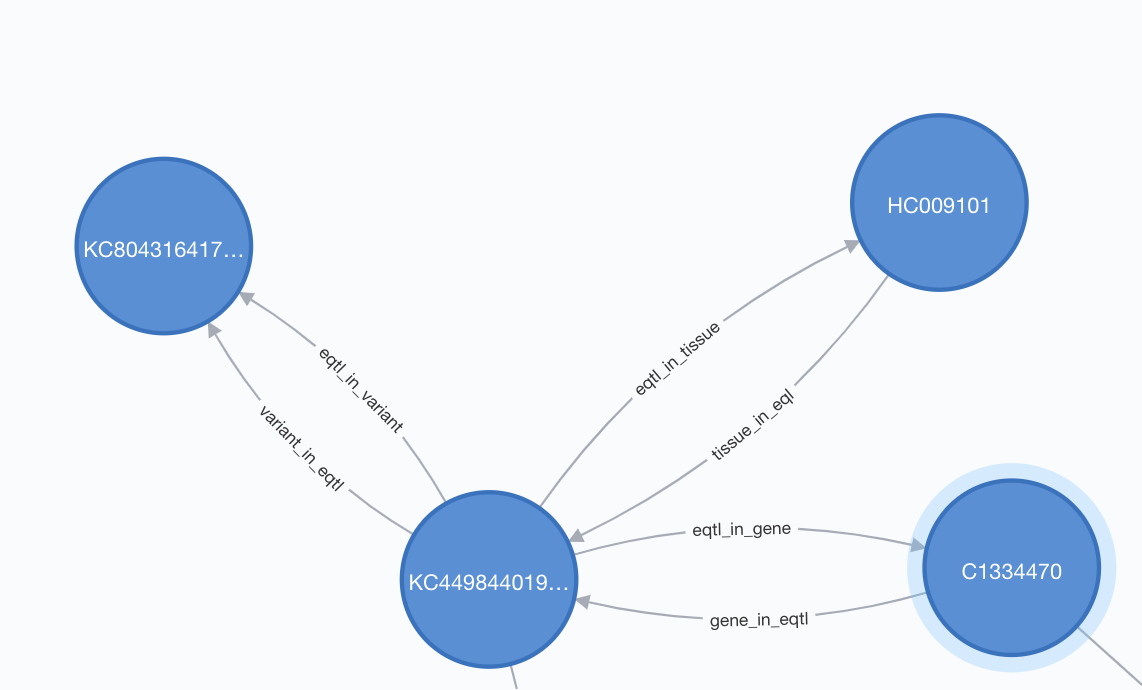

In [70]:
print('The eQTL node is in the center. It is it attached to an UBERON node, a dbSNP/Variant node and')
print('and an HGNC node ')
Image(filename='/Users/stearb/Desktop/R03_screenshots/eqtl_triple.png',width=600)

In [37]:
# GTEX_EQTL --> HGNC
CUI_eqtls_hgnc = eqtl_all_GTEx[['CUI_gtex','CUI_hgnc']].dropna().rename(columns={'CUI_gtex':':START_ID','CUI_hgnc': ':END_ID'})
CUI_eqtls_hgnc[':TYPE'] = 'eqtl_in_gene'
CUI_eqtls_hgnc['SAB']  =  'GTEX_EQTL__HGNC'

# INVERSE,  HGNC --> GTEX_EQTL
CUI_hgnc_eqtls = eqtl_all_GTEx[['CUI_hgnc','CUI_gtex']].dropna().rename(columns={'CUI_gtex':':END_ID','CUI_hgnc': ':START_ID'})
CUI_hgnc_eqtls[':TYPE'] = 'gene_has_eqtl'
CUI_hgnc_eqtls['SAB']  =  'GTEX_EQTL__HGNC'

################################################
################################################

# GTEX_EQTL --> UBERON
CUI_eqtls_uberon = eqtl_all_GTEx[['CUI_gtex','UBERON_CUI']].rename(columns={'CUI_gtex':':START_ID','UBERON_CUI': ':END_ID'}) 
CUI_eqtls_uberon[':TYPE'] = 'eqtl_in_tissue'
CUI_eqtls_uberon['SAB']  =  'GTEX_EQTL__UBERON'

# INVERSE , UBERON --> GTEX_EQTL
CUI_uberon_eqtls = eqtl_all_GTEx[['UBERON_CUI','CUI_gtex']].rename(columns={'CUI_gtex':':END_ID','UBERON_CUI': ':START_ID'}) 
CUI_uberon_eqtls[':TYPE'] = 'tissue_has_eqtl'
CUI_uberon_eqtls['SAB']  =  'GTEX_EQTL__UBERON'
 
################################################
################################################

# GTEX_EQTL --> Variant (dbSNP)
CUI_eqtls_variant = eqtl_all_GTEx[['CUI_gtex','CUI_snp']].rename(columns={'CUI_gtex':':START_ID','CUI_snp': ':END_ID'}) 
CUI_eqtls_variant[':TYPE'] = 'eqtl_in_variant'
CUI_eqtls_variant['SAB']  =  'GTEX_EQTL__DBSNP_151'

# INVERSE, Variant (dbSNP) --> GTEX_EQTL
CUI_variant_eqtls = eqtl_all_GTEx[['CUI_snp','CUI_gtex']].rename(columns={'CUI_gtex':':START_ID','CUI_snp': ':END_ID'}) 
CUI_variant_eqtls[':TYPE'] = 'variant_has_eqtl'
CUI_variant_eqtls['SAB']  =  'GTEX_EQTL__DBSNP_151'


###### Combine CUI-CUIs ########
CUI_CUI_eqtls = pd.concat([ CUI_eqtls_hgnc,CUI_hgnc_eqtls,
                           CUI_eqtls_uberon,CUI_uberon_eqtls,
                           CUI_eqtls_variant,CUI_variant_eqtls])

assert 0 == CUI_CUI_eqtls.isna().sum().sum()

# Dont save here Combine with expression eqtls and save at  the  bottom
#CUI_CUI_eqtls.to_csv('/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/CUI-CUI_eqtl_GTEx.csv',index=False)

In [48]:
#GTEX_eqtl_CUI_CODEs[GTEX_eqtl_CUI_CODEs['CODE'] == 'GTEX_EQTL rs6754226:Prostate:AC016739.2']

In [49]:
#GTEX_eqtl_CUI_CODEs[GTEX_eqtl_CUI_CODEs['CUI']== 'Y2hyMl8xNzY2MTgzODBfQ19UX2IzOA==']

### Format and Save eqtl/gtex CODEs-Terms
Get 
    'CodeID_gtex', 'symbol'  
    'CodeID_gtex', 'gene_id',  
    etc.  
Create SUI and the type of relationship ('rel') and rename term to 'Term' so we can stack them.  
Then stack all CODE-SUI dfs into one master df.

In [72]:
%%capture

## DONT INCLUDE GENE SYMBOL WITH THE OTHER EQTL TERMS. THE EQTL NODE IS ALREADY ATTACHED TO AN HGNC NODE
#SUI_LEN = 14

'''terms_symbols = eqtl_all_GTEx[['symbol','CodeID_gtex']]
terms_symbols['SUI'] = ['KS' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_symbols['symbol']]
terms_symbols['rel'] = 'gene_symbol'
assert terms_symbols.nunique()['symbol'] == terms_symbols.nunique()['SUI']
terms_symbols.rename(columns={'symbol':'Term'},inplace=True)'''
# Ignore MAF for now
# Some of the MAFs overlap with some of the pvalues which leads to some problems...
'''terms_maf = eqtl_all_GTEx[['maf','CodeID_gtex']]
# We get collisions when using 'maf' for the hash, but not when its reversed...
#terms_maf['maf_reverse'] =  eqtl_all_GTEx['maf'].astype(str).apply(lambda x: x[::-1])
terms_maf['SUI'] = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_maf['maf']]
terms_maf['rel'] = 'maf'
assert terms_maf.nunique()['maf'] == terms_maf.nunique()['SUI']
terms_maf.rename(columns={'maf':'Term'},inplace=True)
#terms_maf.drop('maf_reverse',axis=1,inplace=True)'''

## Can we remove gene_start, gene_end, gene_chr here?
- get the chromosome SUIs from UMLS and attach to them.
- We dont need gene_start and gene_end but we do need the eQTL location and chromosome. We can parse both from the variant ID. We can also parse them in the cypher query... 

In [52]:
terms_geneIDs = eqtl_all_GTEx[['gene_id','CodeID_gtex']]
#terms_geneIDs['SUI'] = ['KS' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:SUI_LEN] for uid in terms_geneIDs['gene_id']]

terms_geneIDs['SUI'] = CUIbase64(terms_geneIDs['gene_id'])
terms_geneIDs['rel'] = 'gene_id'

assert terms_geneIDs.nunique()['gene_id'] == terms_geneIDs.nunique()['SUI']
terms_geneIDs.rename(columns={'gene_id':'Term'},inplace=True)

### No Y chromosome eQTLs

In [53]:
#terms_chr = eqtl_all_GTEx[['gene_chr','CodeID_gtex']]
#terms_chr['SUI'] = ['KS' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_chr['gene_chr']]
#terms_chr['rel'] = 'chromosome'; assert terms_chr.nunique()['gene_chr'] == terms_chr.nunique()['SUI']
#terms_chr.rename(columns={'gene_chr':'Term'},inplace=True)

####
#### There are already Chromosome Terms in UMLS, so we dont need to create new SUIs ^^^
####


### OLD WAY OF GETTING CHROMOSOME SUIs
# Load UMLS chromosomes in with their SUIs.
#if LOCAL_CPU: chrom_SUIs = pd.read_csv('/Users/stearb/Desktop/R03_local/data/gtex/UMLS_chromosome_SUIs.csv')
#else: chrom_SUIs = pd.read_csv(helper_data_dir+'UMLS_chromosome_SUIs.csv')
#chrom_SUIs.rename(columns={'chrom':'gene_chr'},inplace=True)


### NEW WAY STRAIGHT FROM CSVs
UMLS_SUIs = pd.read_csv(umls_dir+'SUIs.csv')

chrom_SUIs = UMLS_SUIs.loc[(UMLS_SUIs['name'].str.startswith('chromosome ').astype(bool)) & \
                           (UMLS_SUIs['name'].str.len() < 14)]


chrom_SUIs = chrom_SUIs[~chrom_SUIs['name'].str.contains('p|q|g')]

mito_chrom = UMLS_SUIs[UMLS_SUIs['name'] == 'mitochondrial chromosome']

chrom_SUIs = pd.concat([chrom_SUIs,mito_chrom])

chrom_SUIs = chrom_SUIs.sort_values('name').reset_index(drop=True)
assert len(chrom_SUIs) == 25

chrom_SUIs.rename(columns={'SUI:ID':'SUI','name':'gene_chr'},inplace=True)


chrom_codes = eqtl_all_GTEx[['gene_chr','CodeID_gtex']]

# Overwrite with: Lowercase the 'X' and add 'chromosome' in front to match the UMLS so that we can merge.
chrom_codes['gene_chr'] = ['chromosome '+i for i in chrom_codes['gene_chr'].str.lower()]


# Merge 
terms_chr = pd.merge(chrom_codes,chrom_SUIs,how='inner')

assert len(chrom_codes) == len(terms_chr) # Check that no rows were lost

terms_chr['rel'] = 'on_chromosome'

assert terms_chr.nunique()['gene_chr'] == terms_chr.nunique()['SUI']
terms_chr.rename(columns={'gene_chr':'Term'}, inplace=True)

In [75]:
%%capture
# Dont need gene locations here, we already have them on the GENE_LOCATION Code nodes off the 
# HGNC Concepts (created in the hgnc_anno.ipynb)
# We just need the eQTL location. 

'''################### gene_start Terms #############################
terms_start = eqtl_all_GTEx[['gene_start','CodeID_gtex']]
terms_start['SUI'] = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_start['gene_start']]
terms_start['rel'] = 'gene_start'
assert terms_start.nunique()['gene_start'] == terms_start.nunique()['SUI']
terms_start.rename(columns={'gene_start':'Term'},inplace=True)

################### gene_end Terms #############################
terms_end = eqtl_all_GTEx[['gene_end','CodeID_gtex']]
terms_end['SUI'] = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_end['gene_end']]
terms_end['rel'] = 'gene_end'
assert terms_end.nunique()['gene_end'] == terms_end.nunique()['SUI']
terms_end.rename(columns={'gene_end':'Term'},inplace=True)'''


### Get the eQTL location Code-Term relationships
We Are getting the eQTL relationship from the Variant ID, ie just parsing it out of these strings: chr5_145738784_C_T_b38

In [54]:

################### eQTL Location Terms #############################
terms_eqtl_location  = eqtl_all_GTEx[['variant_id','CodeID_gtex']]

terms_eqtl_location['Term'] = [i.split('_')[1] for i in terms_eqtl_location['variant_id']]

terms_eqtl_location.drop('variant_id',axis=1,inplace=True)

terms_eqtl_location['rel'] = 'eqtl_location'

#terms_eqtl_location['SUI'] = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),
#                                             base=16))[:SUI_LEN] for uid in terms_eqtl_location['Term']]

# Create SUI, just use the CUIbase64 function 
terms_eqtl_location['SUI'] = CUIbase64(terms_eqtl_location['Term'])

assert terms_eqtl_location.nunique()['Term'] == terms_eqtl_location.nunique()['SUI']

### Get the Variant_ID Code-Term relationships

In [55]:
terms_varid = eqtl_all_GTEx[['variant_id','CodeID_gtex']]
#terms_varid['SUI'] = ['KS' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:SUI_LEN] for uid in terms_varid['variant_id']]

terms_varid['SUI'] = CUIbase64(terms_varid['variant_id'])
terms_varid['rel'] = 'variant_id'

assert terms_varid.nunique()['variant_id'] == terms_varid.nunique()['SUI']
terms_varid.rename(columns={'variant_id':'Term'},inplace=True)

### Get the rs_ID Code-Term relationships

In [56]:
terms_rs = eqtl_all_GTEx[['rs_id_dbSNP151_GRCh38p7','CodeID_gtex']]
#terms_rs['SUI'] = ['KS' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:SUI_LEN] for uid in terms_rs['rs_id_dbSNP151_GRCh38p7']]

terms_rs['SUI'] = CUIbase64(terms_rs['rs_id_dbSNP151_GRCh38p7'])
terms_rs['rel'] = 'rs_id_dbSNP151_GRCh38p7'

assert terms_rs.nunique()['rs_id_dbSNP151_GRCh38p7'] == terms_rs.nunique()['SUI']
terms_rs.rename(columns={'rs_id_dbSNP151_GRCh38p7':'Term'},inplace=True)

### Bin P-values
- P-value Terms are handled differently from the other Terms.  
- First, we don't want every single eQTL Code node to haveit's own p-value Term, instead we want to split the p-values up into ~50 bins, And then have Term nodes representing these bins.   
- Secondly, the P value SUIs need their own file and because UMLS does not deal with numerical properties which we will have on the bin nodes ('lowerbound', and 'upperbound').  
- We are no longer saving the bin nodes as their own file, we are just treating them as strings on the Term node, modeled  as 'lowerbound,upperbound' on the name property of the Term. Then we run a cypher query to parse the Upper bound and lower bound from the name property and cast them to floats and set them as upperbound and lowerbound properties.

6.3445e-264


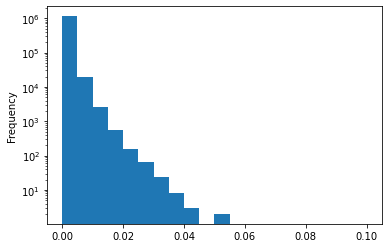

In [57]:
eqtl_all_GTEx['pval_true_df'].plot.hist(bins=20,range=[0,.1])
plt.gca().set_yscale('log')
print(min(eqtl_all_GTEx['pval_true_df']))

In [58]:
# Split p-vals up into bins
terms_pval = eqtl_all_GTEx[['pval_true_df','CodeID_gtex']]

# Define pval Bins 
# Replaced 1e-265 with 0 in the first position
bins = [0,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,.005,.01,.02,.03,.04,.05,.06]

# Bin pvals
terms_pval['bin'] = pd.cut(terms_pval['pval_true_df'], bins)


In [59]:

# Assign bins SUI 
#terms_pval['SUI'] = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in terms_pval['bin']]

# The CUIbase64 function needs strings as input so we need To turn the intervals into strings.
bin_strings_preclip = terms_pval['bin'].astype(str) 

#### MAKE SURE TO REMOVE () AND [] FROM THE INTERVAL STRINGS HERE BEFORE CREATING THE SUIs WITH BASE64
bin_strings = [i[1:-1].replace(' ','') for i in bin_strings_preclip]

In [60]:

terms_pval['SUI'] = CUIbase64(pd.Series(bin_strings))

# Seperate lower bounds and upper  bounds of intervals into 2 columns. 
# These upper/lower bounds will be properties on the node
#terms_pval['bins_lowerbound'] = [i.left for i in terms_pval['bin']]
#terms_pval['bins_upperbound'] = [i.right for i in terms_pval['bin'] ]

terms_pval['rel'] = 'p_value'

assert terms_pval.nunique()['bin'] == terms_pval.nunique()['SUI']

terms_pval.rename(columns={'bin':'Term'},inplace=True)
#terms_pval.drop('pval_true_df',axis=1,inplace=True)

terms_pval['Term'] = [str(i.left)+','+str(i.right) for i in terms_pval['Term']]
#terms_pval.drop(['bins_lowerbound','bins_upperbound'],axis=1,inplace=True)

assert terms_pval[terms_pval['Term'] == '1e-11,1e-10']['SUI'].nunique() == 1

terms_pval.head(2)

# NOT SEPERATING THESE 2 files ANYMORE
# Save terms_pval SUIs file seperately from the other SUI files here, 
# it needs its own import script bc of the numerical properties (intervals)
# Save this and combine it with the EXPRESSION interval SUIs at the end
#SUIs_eqtl_pval_intervals = terms_pval[['SUI','Term','bins_lowerbound',
#                                      'bins_upperbound']].rename(columns={'SUI':'SUI:ID','Term':'name'})

,pval_true_df,CodeID_gtex,Term,SUI,rel
0,0.000010,GTEX_EQTL rs12365753:Heart Atrial Appendage:EXT2,"1e-06,1e-05",MWUtMDYsMWUtMDU=,p_value
1,0.000001,GTEX_EQTL rs1215182979:Heart Atrial Appendage:...,"1e-06,1e-05",MWUtMDYsMWUtMDU=,p_value


### Save eqtl/gtex Terms (SUIs)

In [78]:
# Combine all the CODE-SUI relationships into one CODE-SUIs df.
# NOTE: terms_pval has additional columns we dont need here, so select just the relevant ones. 
CODE_SUIs = pd.concat([terms_geneIDs,
                       terms_chr,
                       terms_eqtl_location, #terms_start, #terms_end,
                       terms_rs,
                       terms_varid,
                       terms_pval[['Term','CodeID_gtex','SUI','rel']]],axis=0)   #,terms_maf,],axis=0)

assert CODE_SUIs.nunique()['Term'] == CODE_SUIs.nunique()['SUI']

# Need to drop duplicates bc there can be multiple Codes  mapped to the  same Term (a gene_id or a chromosome for example)
GTEX_EQTL_SUIs = CODE_SUIs[['SUI','Term']].rename(columns={'SUI':'SUI:ID','Term':'name'}).drop_duplicates()

# Remove chromosome SUIs. They are already in the UMLS SUIs file.
GTEX_EQTL_SUIs = GTEX_EQTL_SUIs[~(GTEX_EQTL_SUIs['SUI:ID'].str.startswith('S') & GTEX_EQTL_SUIs['name'].str.contains('chromosome'))]


### Dont save here Combine with GTEX EXPRESSION SUIs at the bottom, then save (Dont save  here.)
#GTEX_EQTL_SUIs.to_csv('/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/SUIs_GTEx.csv',index=False)

2449998

### Save Code-Term (SUIs)
Some Terms are mapped to multiple CodeIDs This is okay, it makes sense that multiple code nodes map to the same Term node!

In [81]:
# Merge in CUIs to match UMLS import file format
GTEX_EQTL_CODE_SUIs = pd.merge(CODE_SUIs,eqtl_all_GTEx[['CodeID_gtex','CUI_gtex']],on='CodeID_gtex')

GTEX_EQTL_CODE_SUIs = GTEX_EQTL_CODE_SUIs.rename(columns={'CodeID_gtex':':START_ID','SUI':':END_ID',
                                   'rel':':TYPE','CUI_gtex':'CUI'}).drop('Term',axis=1)

# Combine with GTEX EXPRESSION CODE-SUIs at the bottom, then save
#.to_csv('/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/CODE-SUIs_GTEx.csv',index=False)

In [126]:
set(GTEX_CODE_SUIs[':END_ID']) -set(GTEX_SUIs['SUI:ID']) 

{'S11867545',
 'S11867547',
 'S11867548',
 'S11867549',
 'S11867550',
 'S11867551',
 'S11867552',
 'S11867553',
 'S11867584',
 'S1343036',
 'S1744963',
 'S1744979',
 'S1745020',
 'S1745021',
 'S1745039',
 'S1745043',
 'S1745077',
 'S1745094',
 'S1745105',
 'S1745114',
 'S1745119',
 'S1745128',
 'S4035806'}

_________________
________________
________________

# Extract the Gene Expression (Median TPM) dataset
File: GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct  
Description: This file contains genes as rows And tissues as columns. Unlike the other gene expression GTEx dataset we looked at where columns were individual samples (of which we had 17,382 samples), the gene median dataset has only 54 columns corresponding to each tissue type. This gene median data set shows just the median level expression for each tissue.

In [82]:
if LOCAL_CPU:
    gene_median_tpm = '/Users/stearb/desktop/R03_local/data/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct'
else:
    gene_median_tpm = data_dir+'GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct'

gct_obj=parse(gene_median_tpm)

df = gct_obj.data_df
print(df.shape)
df.head(3)

(56200, 54)


cid,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra,Breast - Mammary Tissue,Cells - Cultured fibroblasts,Cells - EBV-transformed lymphocytes,Cervix - Ectocervix,Cervix - Endocervix,Colon - Sigmoid,Colon - Transverse,Esophagus - Gastroesophageal Junction,Esophagus - Mucosa,Esophagus - Muscularis,Fallopian Tube,Heart - Atrial Appendage,Heart - Left Ventricle,Kidney - Cortex,Kidney - Medulla,Liver,Lung,Minor Salivary Gland,Muscle - Skeletal,Nerve - Tibial,Ovary,Pancreas,Pituitary,Prostate,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
ENSG00000227232.5,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,1.69285,1.56605,4.99231,5.72099,2.48317,2.14667,1.68599,1.74811,1.53899,1.44167,2.73049,1.74194,4.43876,1.6786,2.49477,5.62935,7.09749,4.64777,3.59509,4.32641,3.11749,4.10335,6.13409,1.52031,0.924962,2.77081,2.21451,1.76541,4.50841,3.52767,1.41667,6.68531,6.6341,1.80871,5.42546,7.08318,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743
ENSG00000278267.1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000


In [86]:
# Show names of the fields for the object
gct_obj.__dict__.keys()

dict_keys(['logger', 'src', 'version', 'data_df', 'row_metadata_df', 'col_metadata_df', 'multi_index_df', '_initialized'])

In [87]:
# Show row (gene) metadata (Column (tissue) metadata is just the column names)
gct_obj.row_metadata_df.head(3)

rhd,Description
rid,
ENSG00000223972.5,DDX11L1
ENSG00000227232.5,WASH7P
ENSG00000278267.1,MIR6859-1


In [83]:
# Reformat and rename both axes, also use stack to flatten the dataframe (make tissues into a column)
medgene_flat = df.stack().reset_index().rename(columns={'rid':'Transcript ID',
                                                        'cid':'tissue',0:'Median_TPM'})

# Reformat tissue strings so they match the UBERON mappings data
medgene_flat['tissue'] = medgene_flat['tissue'].str.replace(' - ',' ').str.replace('\(','').str.replace('\)','')
print(medgene_flat.shape)
medgene_flat.head(3)

(3034800, 3)


,Transcript ID,tissue,Median_TPM
0,ENSG00000223972.5,Adipose Subcutaneous,0.0
1,ENSG00000223972.5,Adipose Visceral Omentum,0.0
2,ENSG00000223972.5,Adrenal Gland,0.0


In [89]:
medgene_flat['Transcript ID'].drop_duplicates().nunique()

56200

#### Look at row (gene) metadata and map them to HGNC IDs

In [84]:
gtx_genes = gct_obj.row_metadata_df['Description'].to_frame()
gtx_genes['Transcript ID'] = gtx_genes.index
gtx_genes.rename(columns={'Description':'symbol'},inplace=True)
gtx_genes.reset_index(drop=True, inplace=True)

print(f'# of unique genes: {gct_obj.row_metadata_df["Description"].nunique()} (some overlap)')
print(f'# of unique transcript IDs: {gtx_genes.index.nunique()} (no overlap)')
#gtx_genes.head()

# of unique genes: 54592 (some overlap)
# of unique transcript IDs: 56200 (no overlap)


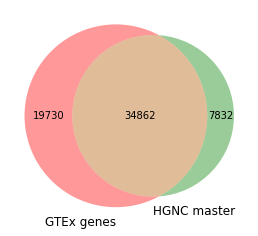

In [91]:
# how much overlap is there with the HGNC master genes list and the gtx_genes?
venn2([set(gtx_genes['symbol']),
       set(hgnc_master['symbol'])],
       set_labels = ('GTEx genes', 'HGNC master')); plt.show()

### Use the master hgnc list from the website and filter by gtx_genes so we only get the overlap

In [85]:
# Merge in HGNC IDs from hgnc_master_filtbygtex
cols2include = ['symbol','hgnc_id','name','locus_group','locus_type','location']
                                        #,'entrez_id','ensembl_gene_id','uniprot_ids']

symbols_hgnc=pd.merge(left=gtx_genes,right=hgnc_master[cols2include],   # include more gene IDs/gene data here
                           how='inner',
                           on='symbol')#.dropna()#.drop_duplicates('Transcript ID')

symbols_hgnc.head(3)

,symbol,Transcript ID,hgnc_id,name,locus_group,locus_type,location
0,DDX11L1,ENSG00000223972.5,HGNC:37102,DEAD/H-box helicase 11 like 1 (pseudogene),pseudogene,pseudogene,1p36.33
1,WASH7P,ENSG00000227232.5,HGNC:38034,"WASP family homolog 7, pseudogene",pseudogene,pseudogene,1p36.33
2,MIR6859-1,ENSG00000278267.1,HGNC:50039,microRNA 6859-1,non-coding RNA,"RNA, micro",1p36.33


#### Now map COLUMN names (tissues) and UBERON codes. onto medgene_flat

In [86]:
medgene_flat_ub = pd.merge(left=medgene_flat,right=SAMPID_2_TISSUE_unique,on='tissue')
medgene_flat_ub.head(3)

,Transcript ID,tissue,Median_TPM,SMTS,SMUBRID
0,ENSG00000223972.5,Adipose Subcutaneous,0.00000,Adipose Tissue,0002190
1,ENSG00000227232.5,Adipose Subcutaneous,4.06403,Adipose Tissue,0002190
2,ENSG00000278267.1,Adipose Subcutaneous,0.00000,Adipose Tissue,0002190


In [87]:
# Join flattened median gene dataset with the HGNC IDs (and other gene info)
medgene_merge  = pd.merge(left=medgene_flat_ub,
                     right=symbols_hgnc,
                     how='inner',
                     on='Transcript ID').dropna()

print(medgene_merge.shape)
medgene_merge.head(3)

(1903338, 11)


,Transcript ID,tissue,Median_TPM,SMTS,SMUBRID,symbol,hgnc_id,name,locus_group,locus_type,location
0,ENSG00000223972.5,Adipose Subcutaneous,0.0,Adipose Tissue,0002190,DDX11L1,HGNC:37102,DEAD/H-box helicase 11 like 1 (pseudogene),pseudogene,pseudogene,1p36.33
1,ENSG00000223972.5,Adipose Visceral Omentum,0.0,Adipose Tissue,0010414,DDX11L1,HGNC:37102,DEAD/H-box helicase 11 like 1 (pseudogene),pseudogene,pseudogene,1p36.33
2,ENSG00000223972.5,Adrenal Gland,0.0,Adrenal Gland,0002369,DDX11L1,HGNC:37102,DEAD/H-box helicase 11 like 1 (pseudogene),pseudogene,pseudogene,1p36.33


### Merge in HGNC CUIs from the umls_genes (HGNC_IDs--HGNC CUI mapping)

In [88]:
medgene_merge_2  =  pd.merge(left=umls_genes,right=medgene_merge,on='hgnc_id')
#assert medgene_merge.shape[0] == medgene_merge_2.shape[0]

In [89]:
medgene_merge_2.shape

(1903392, 12)

In [90]:
medgene_merge.shape

(1903338, 11)

In [91]:
### Merge in UBERON CUIs from the umls_genes (HGNC_IDs--HGNC CUI mapping)
medgene_merge_2.rename(columns={'SMUBRID':'UBERON_code'},inplace=True)

# Drop rows where UBERON code starts with 'EFO', which drops 70,738 rows
medgene_merge_2 = medgene_merge_2[~medgene_merge_2['UBERON_code'].str.contains('EFO')]

In [92]:
##############################################
####### ALL OF THESE CODES ARE IN UMLS NOW ###
##############################################

# We need to manually add the UMLS CUIs for some of these UBERON codes (again.) 
# As a reminder, they do not exist in UMLS as UBERON CUIs, which we searched for,
# bc they were in UMLS (from NCIT) before UBERON was added. (meaning they didnt appear
# in the search when I searched for UBERON Concepts, so I need to add them manually here)

#extra_uberon_xref =  pd.DataFrame( [['0000458','C0227837'], # endocervix
#                                   ['0001255','C0005682'],  # urinary bladder
#                                   ['0003889','C0015560'],  # fallopian tube
#                                   ['0012249','C0227829']], # ectocervix
#                                     columns=['UBERON_code','UBERON_CUI'])


# So no need to add in any extra codes
#umls_uberon_xref_2 = umls_uberon_xref.append(extra_uberon_xref) # add these extra UBERON Code-CUI mappings to the rest

umls_uberon_xref_2 = umls_uberon_xref

In [93]:
umls_uberon_xref_2[umls_uberon_xref_2['UBERON_code'].duplicated() == True]

,UBERON_code,UBERON_CUI
9813261,0005985,C0010075
9813293,0002028,C1522180
9815619,0003129,C0037303
9815752,0000013,C0039044
9816001,0003128,VUJFUk9OIDAwMDMxMjg=
...,...,...
9905250,0002371,C0005953
9905261,0012419,C0227365
9905274,0012418,VUJFUk9OIDAwMTI0MTg=
9905282,0002184,C0444439


In [81]:
umls_uberon_xref_2[umls_uberon_xref_2['UBERON_code'] == '0001676']

,UBERON_code,UBERON_CUI
9802018,0001676,C0028784


In [82]:
umls_uberon_xref_2[umls_uberon_xref_2['UBERON_code'] == '0004760']

,UBERON_code,UBERON_CUI
9802036,0004760,C0162322
9821970,0004760,C1321423


In [83]:

umls_uberon_xref_2[umls_uberon_xref_2['UBERON_code'] == '0001085']

,UBERON_code,UBERON_CUI
9802123,0001085,C0205031


### Merge in UBERON CUIs

In [94]:
medgene_merge_3  =  pd.merge(left=medgene_merge_2,right=umls_uberon_xref_2,on='UBERON_code') 
#assert medgene_merge_2.shape[0]==medgene_merge_3.shape[0]

In [95]:
medgene_merge_2.shape#isna().sum()

(1832896, 12)

In [96]:
medgene_merge_3.shape#isna().sum()

(2009136, 13)

In [106]:
###### Look into 'Heart' related UBERON codes. The UBERON code for Heart is not in the graph

In [107]:
#gene_median_tpm_new_dwnld = '/Users/stearb/Downloads/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct'


#gct_obj_new=parse(gene_median_tpm)

#df_new = gct_obj.data_df
#print(df_new.shape)
#df_new.head(3)

In [108]:
#gtex_heart_terms = 'Heart - Left Ventricle', 'Heart - Atrial Appendage',  'Artery - Aorta'

In [109]:
#medgene_merge_3[medgene_merge_3['tissue'] == 'Artery Aorta']

In [110]:
#medgene_merge_3.drop_duplicates(CODE_GTEX_Expression)

#medgene_merge_3['CODE_GTEX_Expression'].nunique()

### The last thing to do for the median_gene_tpm data set is to add unique code/Concept node identifiers

We must include the UBERON_CUI when making the 'CODE_GTEX_Expression'. Without the UBERONN_CUI, every row will not be unique, even if we include the UBERON_code. This is because in the updated UMLS database (the FREEZE), many UBERON Codes map to more than one Concept.

In [97]:
# Turn the  'Median_TPM' into strings so we can include them in the unique hash ID 
median_tpm_strs = [str(i) for i in medgene_merge_3['Median_TPM']]

# there are no columns with 100% unique values so we need to combine 3         FIX:  ' - ' +
# columns to create unique strings that we can then hash
medgene_merge_3['CODE_GTEX_Expression'] = medgene_merge_3['Transcript ID'] + ':' + \
                                          medgene_merge_3['tissue'] + ':' + \
                                           medgene_merge_3['UBERON_CUI'] +':' + \
                                           median_tpm_strs

### There are still ~100 rows where 'CODE_GTEX_Expression' is duplicated, just drop them for now
### Must fix this at some point though.



In [98]:
medgene_merge_3.drop_duplicates('CODE_GTEX_Expression',inplace=True)

In [99]:

medgene_merge_3['CodeID_GTEX_Expression'] = ['GTEX_EXP '+i for i in medgene_merge_3['CODE_GTEX_Expression']]

# USE BASE-64 METHOD
# create a 'GTEX EXP' CUI using a hash on that column.
#medgene_merge_3['CUI_GTEX_Expression']  = ['KC' + str(int(hashlib.sha256(uid.encode('utf8')).hexdigest(),
#                                                      base=16))[:CUI_LEN] for uid in medgene_merge_3['CODE_GTEX_Expression']]

# Make CUIs
medgene_merge_3['CUI_GTEX_Expression'] = CUIbase64(medgene_merge_3['CodeID_GTEX_Expression'])


# Check for collisions
assert len(medgene_merge_3['CODE_GTEX_Expression'].unique()) == medgene_merge_3.shape[0]
assert medgene_merge_3['CODE_GTEX_Expression'].unique().shape == medgene_merge_3['CodeID_GTEX_Expression'].unique().shape 
assert  medgene_merge_3['CODE_GTEX_Expression'].unique().shape== medgene_merge_3['CUI_GTEX_Expression'].unique().shape

In [100]:
#  Select just the columns we need (CUIs and CodeIDs)
medgene_select = medgene_merge_3[['CUI_GTEX_Expression','CODE_GTEX_Expression','CodeID_GTEX_Expression','CUI_hgnc','Median_TPM','UBERON_CUI']]
medgene_select.head(3)

,CUI_GTEX_Expression,CODE_GTEX_Expression,CodeID_GTEX_Expression,CUI_hgnc,Median_TPM,UBERON_CUI
0,R1RFWF9FWFAgRU5TRzAwMDAwMTUxMzQ4LjEzOkFkaXBvc2...,ENSG00000151348.13:Adipose Subcutaneous:C02223...,GTEX_EXP ENSG00000151348.13:Adipose Subcutaneo...,C0694879,39.065899,C0222331
1,R1RFWF9FWFAgRU5TRzAwMDAwMjY1MTkwLjY6QWRpcG9zZS...,ENSG00000265190.6:Adipose Subcutaneous:C022233...,GTEX_EXP ENSG00000265190.6:Adipose Subcutaneou...,C1332096,0.059548,C0222331
2,R1RFWF9FWFAgRU5TRzAwMDAwMTk4MDQ5LjY6QWRpcG9zZS...,ENSG00000198049.6:Adipose Subcutaneous:C022233...,GTEX_EXP ENSG00000198049.6:Adipose Subcutaneou...,C1332123,0.000000,C0222331


### There are 2 CUI-CUI  mappings and 1 CUI-CodeID mapping we need for the GTEX EXP CUIs
- CUI-CUIs
    - GTEX_Expression CUI -- HGNC CUI
    - GTEX_Expression CUI -- UBERON CUI
- CUI-CODE
    - GTEX_Expression CUI -- GTEX_Expression CodeID

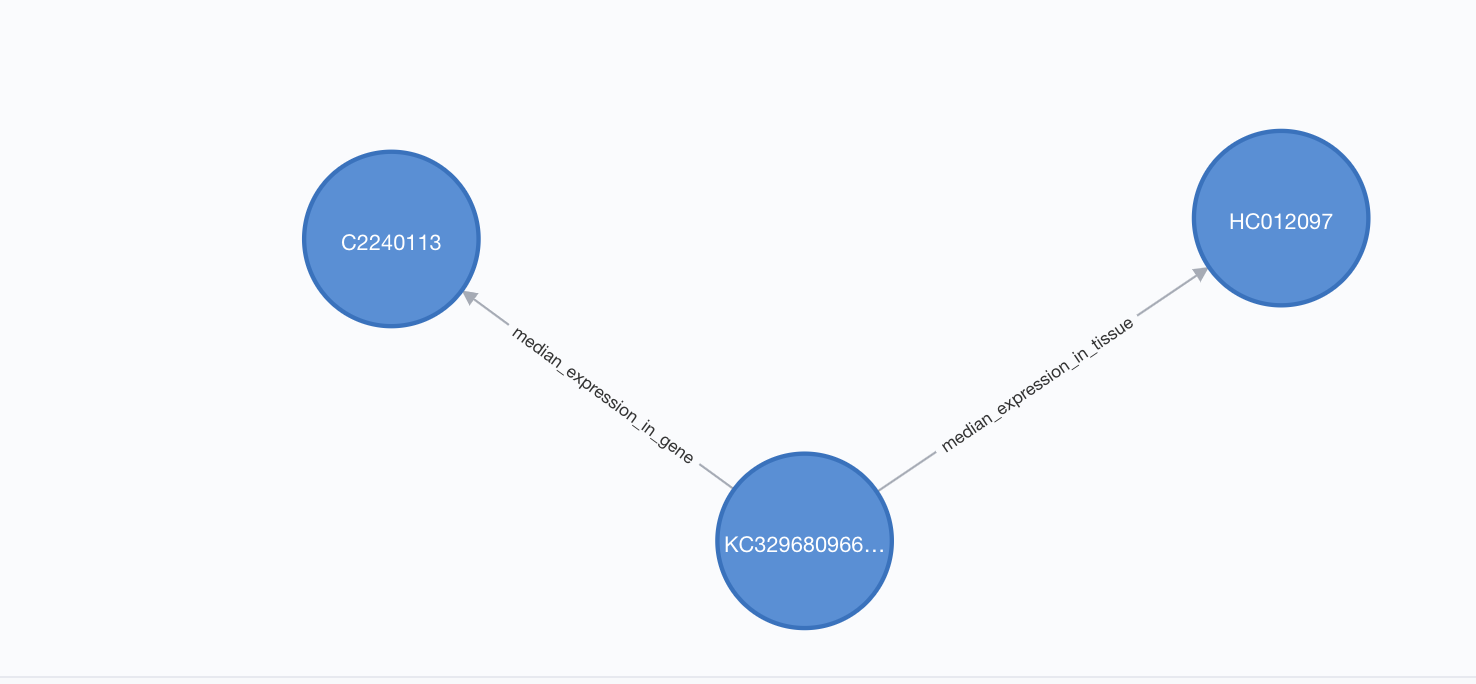

In [115]:
# UPDATE
Image(filename='/Users/stearb/Desktop/Full_Query_Steps_Concepts/Median_TPM.png',width=600)

CUIs (combine the Expression CUIs with the eQTL CUIs and save)

In [101]:
GTEX_Ex_CUIs = pd.DataFrame(np.transpose([medgene_select['CUI_GTEX_Expression'].drop_duplicates().values]
                                          ),columns=['CUI:ID']) 

CUIs_all_eqtl_2=CUIs_all_eqtl.to_frame().rename(columns={0:'CUI:ID'})#,inplace=True)

# Combine eqtl CUIs with med expression CUIs
CUIs_all = CUIs_all_eqtl_2.append(GTEX_Ex_CUIs)

assert CUIs_all.shape  == CUIs_all.drop_duplicates().shape 


CUIs_all.to_pickle(output_dir+'GTEx/CUIs_GTEx.pickle')



CUI-CUIs (and combine the Expression CUI-CUIs with the eQTL CUI-CUIs and save)

# Transform data into Concept - to - Concept schema

In [102]:
# GTEX_EXP --> HGNC 
GTEX_Ex_2_HGNC = medgene_select[['CUI_GTEX_Expression','CUI_hgnc']].rename(columns={'CUI_GTEX_Expression':':START_ID','CUI_hgnc':':END_ID'})
GTEX_Ex_2_HGNC[':TYPE'] = 'median_expression_in_gene'
GTEX_Ex_2_HGNC['SAB'] = 'GTEX_EXP__HGNC'

# INVERSE, HGNC --> GTEX_EXP
HGNC_2_GTEX_Ex = medgene_select[['CUI_hgnc','CUI_GTEX_Expression']].rename(columns={'CUI_GTEX_Expression':':END_ID','CUI_hgnc':':START_ID'})
HGNC_2_GTEX_Ex[':TYPE'] = 'gene_has_median_expression'
HGNC_2_GTEX_Ex['SAB'] = 'GTEX_EXP__HGNC'

# GTEX_EXP --> UBERON
GTEX_Ex_2_UBERON  = medgene_select[['CUI_GTEX_Expression','UBERON_CUI']].rename(columns={'CUI_GTEX_Expression':':START_ID','UBERON_CUI':':END_ID'})
GTEX_Ex_2_UBERON[':TYPE'] = 'median_expression_in_tissue'
GTEX_Ex_2_UBERON['SAB'] = 'GTEX_EXP__UBERON'


# UBERON -->  GTEX_EXP
UBERON_2_GTEX_Ex  = medgene_select[['UBERON_CUI','CUI_GTEX_Expression']].rename(columns={'CUI_GTEX_Expression':':END_ID','UBERON_CUI':':START_ID'})
UBERON_2_GTEX_Ex[':TYPE'] = 'tissue_has_median_expression'
UBERON_2_GTEX_Ex['SAB'] = 'GTEX_EXP__UBERON'


# Combine CUI-CUIs
GTEX_Ex_CUI_CUI = pd.concat([GTEX_Ex_2_HGNC,HGNC_2_GTEX_Ex,GTEX_Ex_2_UBERON,UBERON_2_GTEX_Ex])

# Combine with the eQTL CUI-CUIs
CUI_CUIs_all = pd.concat([GTEX_Ex_CUI_CUI, CUI_CUI_eqtls]) 

# Check that there are no duplicates when we combine the 2 CUI-CUI dataframes
assert CUI_CUIs_all.duplicated().sum() == 0


CUI_CUIs_all.to_pickle(output_dir+'GTEx/CUI_CUI_GTEx.pickle')
    

CODEs (and combine the Expression Codes with the eQTL Codes and save)

In [103]:
GTEX_Ex_CODEs = medgene_select[['CodeID_GTEX_Expression','CODE_GTEX_Expression']].rename(columns={'CodeID_GTEX_Expression':'CodeID',
                                                                                   'CODE_GTEX_Expression':'CODE'})
GTEX_Ex_CODEs['SAB'] = 'GTEX_EXP'

GTEX_Ex_CODEs = GTEX_Ex_CODEs[['CodeID','SAB','CODE']]

# Add in eqtl CODEs
CODEs_all = pd.concat([GTEX_Ex_CODEs,gtex_codes_eqtl])

assert CODEs_all.shape == CODEs_all.drop_duplicates().shape
assert CODEs_all.nunique()['CodeID'] == CODEs_all.nunique()['CODE']


CODEs_all.to_pickle(output_dir+'GTEx/CODEs_GTEx.pickle')

###  CUI_CODEs (and combine the Expression CUI-Codes with the eQTL CUI-Codes and save)
### fix duplicates issues
There arent duplicates in GTEX_Expression CUI_CODE and there arent duplicates in GTEX eqtl CUI_CODE

In [105]:
GTEX_Ex_CUI_CODE  = medgene_select[['CUI_GTEX_Expression',
                                    'CodeID_GTEX_Expression']].rename(columns={'CUI_GTEX_Expression':'CUI',
                                                                               'CodeID_GTEX_Expression':'CODE'})
# Add in eqtl CUI-CODEs
GTEX_CUI_CODEs_all  = pd.concat([GTEX_Ex_CUI_CODE,GTEX_eqtl_CUI_CODEs])

assert GTEX_CUI_CODEs_all.shape == GTEX_CUI_CODEs_all.drop_duplicates().shape

# No Overlap between GTEX eqtl CUIs and GTEX Expression CUIs
assert set() == set(GTEX_eqtl_CUI_CODEs['CUI']).intersection(set(GTEX_Ex_CUI_CODE['CUI']))


GTEX_CUI_CODEs_all.to_pickle(output_dir+'GTEx/CUI_CODEs_GTEx.pickle')


There is actually no overlap between the SUI:IDs or the names/Terms between the EQTL SUIs (eqtl pvals) and the EXP SUIs (TPM values)

In [70]:
#venn2([set(GTEX_EXP_SUIs['SUI:ID']),set(GTEX_EQTL_SUIs['SUI:ID'])])
#venn2([set(GTEX_EXP_SUIs['name']),set(GTEX_EQTL_SUIs['name'])])

In [71]:
#medgene_select['Median_TPM'].hist(bins=100)    
# less than 2,000  = 1,837,599
#  total = 1,839,188
# zeros = 742,955
#medgene_select[(medgene_select['Median_TPM'] > 50000)]['Median_TPM'].hist()
#max(medgene_select[(medgene_select['Median_TPM'] != 0)]['Median_TPM'])

In [86]:
max(medgene_select['Median_TPM'])

267405.0

### Put TPM values into bins

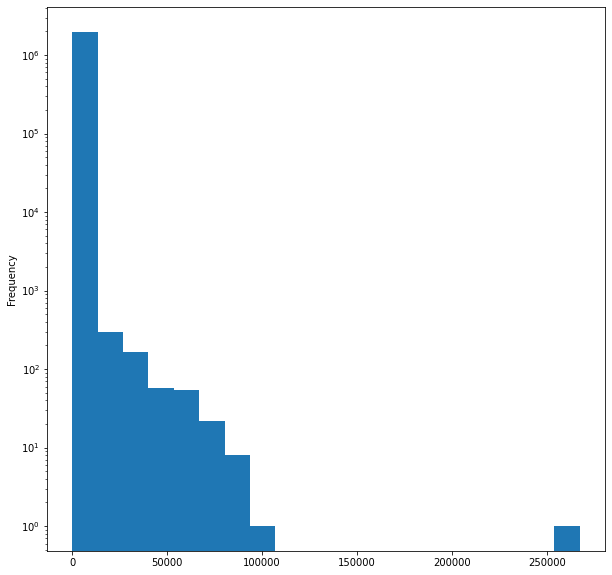

In [85]:
medgene_select['Median_TPM'].plot(kind='hist',bins=20,figsize=(10,10))
plt.gca().set_yscale('log')

In [87]:
np.array(tpm_bins)

array([0.0e+00, 7.0e-04, 8.0e-04, 9.0e-04, 1.0e-03, 2.0e-03, 3.0e-03,
       4.0e-03, 5.0e-03, 6.0e-03, 7.0e-03, 8.0e-03, 9.0e-03, 1.0e-02,
       2.0e-02, 3.0e-02, 4.0e-02, 5.0e-02, 6.0e-02, 7.0e-02, 8.0e-02,
       9.0e-02, 1.0e-01, 2.0e-01, 3.0e-01, 4.0e-01, 5.0e-01, 6.0e-01,
       7.0e-01, 8.0e-01, 9.0e-01, 1.0e+00, 2.0e+00, 3.0e+00, 4.0e+00,
       5.0e+00, 6.0e+00, 7.0e+00, 8.0e+00, 9.0e+00, 1.0e+01, 1.1e+01,
       1.2e+01, 1.3e+01, 1.4e+01, 1.5e+01, 1.6e+01, 1.7e+01, 1.8e+01,
       1.9e+01, 2.0e+01, 2.1e+01, 2.2e+01, 2.3e+01, 2.4e+01, 2.5e+01,
       2.6e+01, 2.7e+01, 2.8e+01, 2.9e+01, 3.0e+01, 3.1e+01, 3.2e+01,
       3.3e+01, 3.4e+01, 3.5e+01, 3.6e+01, 3.7e+01, 3.8e+01, 3.9e+01,
       4.0e+01, 4.1e+01, 4.2e+01, 4.3e+01, 4.4e+01, 4.5e+01, 4.6e+01,
       4.7e+01, 4.8e+01, 4.9e+01, 5.0e+01, 5.1e+01, 5.2e+01, 5.3e+01,
       5.4e+01, 5.5e+01, 5.6e+01, 5.7e+01, 5.8e+01, 5.9e+01, 6.0e+01,
       6.1e+01, 6.2e+01, 6.3e+01, 6.4e+01, 6.5e+01, 6.6e+01, 6.7e+01,
       6.8e+01, 6.9e

In [106]:
# Only 2 TPM values below 0.0007

tpm_bins = list([0.0000000,7e-4,8e-4,9e-4]) + list(np.linspace(1e-3,9e-3,9)) + \
           list(np.round(np.linspace(1e-2,9e-2,9),2)) + list(np.round(np.linspace(.1,1,10),2)) + \
           list(np.linspace(2,100,99)) + list(np.arange(100,1100,100)[1:]) +  \
            list(np.arange(2000,11000,1000)) + list(np.arange(20000,110000,10000)) + [300000]

# Seperate main df into df's where 'Median_TPM' is == 0 , and where 'Median_TPM' is != 0
tpm_0s = medgene_select[medgene_select['Median_TPM'] == 0.00] 
tpm_intervals = medgene_select[medgene_select['Median_TPM'] != 0.00] 

# Create TPM Bins  
tpm_intervals['tpm_bins'] = pd.cut(tpm_intervals['Median_TPM'], tpm_bins)

# Create SUIs for intervals
#tpm_intervals['SUI_tpm_bins']  = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in tpm_intervals['tpm_bins']]

# Save expression bins as strings first
bin_strings_exp_preclip = tpm_intervals['tpm_bins'].astype(str)


In [107]:
#### MAKE SURE TO REMOVE () AND [] FROM THE INTERVAL STRINGS HERE BEFORE CREATING THE SUIs WITH BASE64
bin_strings_exp = [i[1:-1].replace(' ','') for i in bin_strings_exp_preclip]

In [108]:

# Create SUIs the new way.
tpm_intervals['SUI_tpm_bins'] = CUIbase64(pd.Series(bin_strings_exp))


# Seperate lower bounds and upper  bounds of intervals into 2 columns, unless its Nan (float), 
# then just set both bounds to 0.0
# CHEECK WHAT THE FLOATS IN HERE  ARE, THEY SHOULDNT BE 0's
tpm_intervals['bins_lowerbound'] = [i.left if type(i) is not float else 0.0 for i in tpm_intervals['tpm_bins'] ]
tpm_intervals['bins_upperbound'] = [i.right if type(i) is not float else 0.0 for i in tpm_intervals['tpm_bins'] ]

tpm_intervals.drop('tpm_bins',axis=1,inplace=True)


# Create SUIs for  TPM == 0. It will be the same SUI (the 0.0 SUI) for all of these
#tpm_0s['SUI_tpm_bins']  = ['KS' + str(int(hashlib.sha256(str(uid).encode('utf8')).hexdigest(),base=16))[:SUI_LEN] for uid in tpm_0s['Median_TPM']]

bin_strings_exp_0 = tpm_0s['Median_TPM'].astype(str)

tpm_0s['SUI_tpm_bins'] = CUIbase64(bin_strings_exp_0)

# Add columns to concat with main tpm_intervals
tpm_0s['bins_upperbound'] = 0.0
tpm_0s['bins_lowerbound'] = 0.0

# Join them back together
tpm_all_intervals =  pd.concat([tpm_intervals,tpm_0s]).reset_index(drop=True)

In [109]:
# Create 'name' column for interval Terms.
tpm_all_intervals['name'] = tpm_all_intervals['bins_lowerbound'].astype(str) +','+ tpm_all_intervals['bins_upperbound'].astype(str)

tpm_all_intervals.drop(['bins_lowerbound','bins_upperbound'],axis=1,inplace=True)

In [110]:
tpm_all_intervals.head(3)

,CUI_GTEX_Expression,CODE_GTEX_Expression,CodeID_GTEX_Expression,CUI_hgnc,Median_TPM,UBERON_CUI,SUI_tpm_bins,name
0,R1RFWF9FWFAgRU5TRzAwMDAwMTUxMzQ4LjEzOkFkaXBvc2...,ENSG00000151348.13:Adipose Subcutaneous:C02223...,GTEX_EXP ENSG00000151348.13:Adipose Subcutaneo...,C0694879,39.065899,C0222331,MzkuMCw0MC4w,"39.0,40.0"
1,R1RFWF9FWFAgRU5TRzAwMDAwMjY1MTkwLjY6QWRpcG9zZS...,ENSG00000265190.6:Adipose Subcutaneous:C022233...,GTEX_EXP ENSG00000265190.6:Adipose Subcutaneou...,C1332096,0.059548,C0222331,MC4wNSwwLjA2,"0.05,0.06"
2,R1RFWF9FWFAgRU5TRzAwMDAwMTcyNzI0LjExOkFkaXBvc2...,ENSG00000172724.11:Adipose Subcutaneous:C02223...,GTEX_EXP ENSG00000172724.11:Adipose Subcutaneo...,C1332682,24.295401,C0222331,MjQuMCwyNS4w,"24.0,25.0"


### Save all SUIs (and combine the Expression SUIs with the eQTL SUIs and save)
(Combine GTEX EXPRESSION SUIs  with GTEX EQTL)  
Columns: SUI:ID, name
        
Add the 0 SUI and the interval SUIs to the main SUI file  
Add just the 0 SUI to the SUIs_all (EQTL SUIs + EXPRESSION SUIs)  
We need a seperate script to add the TPM interval SUIs bc they contain numerical properties  
BUT, add both the 0 SUIs and the interval SUIs to the CODE-SUIs_all, bc the relationships (CODE-SUIs) can be put in the ,UMLS master CODE-SUIs file.

In [127]:
# Add in all intervals
GTEX_EXP_SUIs = tpm_all_intervals[['SUI_tpm_bins','name']].rename(columns={'SUI_tpm_bins':'SUI:ID'
                                                               }).drop_duplicates()

# Combine GTEX_EXP_SUIs with GTEX EQTL SUIs
GTEX_SUIs = pd.concat([GTEX_EXP_SUIs,GTEX_EQTL_SUIs]).drop_duplicates()

assert len(GTEX_SUIs[GTEX_SUIs['SUI:ID'].duplicated()]) == 0


GTEX_SUIs.to_pickle(output_dir+'GTEx/SUIs_GTEx.pickle')

In [131]:
GTEX_SUIs[GTEX_SUIs['SUI:ID'] == 'KDFlLTExLCAxZS0xMF0=']

,SUI:ID,name


In [132]:
# compare overlap b/t both SUI datasets (should be none)
#venn2([set(GTEX_EXP_SUIs['SUI:ID']),set(GTEX_EQTL_SUIs['SUI:ID'])]);plt.show()

### CODE-SUI (and combine the Expression CODE-SUIs with the eQTL CODE-SUIs and save)
cols = :START_ID, :END_ID, :TYPE, CUI  
:START_ID = CodeID 

In [128]:
#code_suis_0 = tpm_0s[['CodeID_GTEX_Expression',
#                             'SUI_0','CUI_GTEX_Expression']].rename(columns={
#                                                            'CodeID_GTEX_Expression':':START_ID',
#                                                            'SUI_0':':END_ID',
#                                                            'CUI_GTEX_Expression':'CUI'}).drop_duplicates()

GTEX_EXP_CODE_SUIs = tpm_all_intervals[['CodeID_GTEX_Expression',
                                     'SUI_tpm_bins',
                                     'CUI_GTEX_Expression']].rename(columns={
                                                            'CodeID_GTEX_Expression':':START_ID',
                                                            'SUI_tpm_bins':':END_ID',
                                                            'CUI_GTEX_Expression':'CUI'}).drop_duplicates()

# Combine 0 CODE-SUI and interval CODE-SUIs
#GTEX_EXP_CODE_SUIs = pd.concat([code_suis_0,code_suis_intervals])

GTEX_EXP_CODE_SUIs[':TYPE'] = 'TPM'

#### COMBINE EXP and EQTL CODE-SUIs
GTEX_CODE_SUIs= pd.concat([GTEX_EQTL_CODE_SUIs,GTEX_EXP_CODE_SUIs])

# Comment this line out, see 2 cells below.
#assert len(set(GTEX_EQTL_CODE_SUIs[':END_ID']).intersection(set(GTEX_EXP_CODE_SUIs[':END_ID']))) == 0


GTEX_CODE_SUIs.to_pickle(output_dir+'GTEx/CODE_SUIs_GTEx.pickle')

In [1]:
# Show all CODE-SUI relationships
#Counter(GTEX_CODE_SUIs[':TYPE'])

# End of GTEx data formatting. 
Everything else below is not currently being used.

### Set parameter to save GTEX_EQTL p-value Terms and GTEX_EXP TPM Terms as floats or as strings.

In [ ]:
#TERMS_AS_FLOATS = False

### Save Interval SUI nodes seperately if TERMS_AS_FLOATS is True

In [ ]:
%%capture
'''#Save this as its own file. Cant combine with the UMLS SUIs.csv import file because we need to include
# the numerical intervals as properties
SUIs_tpm_intervals = tpm_intervals[['SUI_tpm_bins','tpm_bins','bins_lowerbound','bins_upperbound']].rename(
                                columns={'SUI_tpm_bins':'SUI:ID','tpm_bins':'name'})

GTEX_SUI_intervals = pd.concat([SUIs_tpm_intervals,SUIs_eqtl_pval_intervals])

# Add :float, to interval columns, so neo4j knows they are integers
GTEX_SUI_intervals.rename(columns={'bins_upperbound':'bins_upperbound:float',
                                   'bins_lowerbound':'bins_lowerbound:float'},inplace=True)

# And drop duplicates, there are only a couple hundred 'bin' Term nodes total
GTEX_SUI_intervals.drop_duplicates(inplace=True)

# Comment this line out, see cell below.
#assert len(set(SUIs_eqtl_pval_intervals['SUI:ID']).intersection(set(SUIs_tpm_intervals['SUI:ID']))) == 0


GTEX_SUI_intervals.to_csv('/Users/stearb/desktop/hubmap-kg/numeric_terms/SUIs_GTEX_EXP_intervals.csv',index=False)
GTEX_SUI_intervals.to_csv('/Users/stearb/desktop/R03_local/data/ingest_files/GTEx/SUIs_GTEX_EXP_intervals.csv',index=False)
'''

### Should the bins for the TPM and bins for the eqtl p-values be allowed to overlap?

In [ ]:
# These overlap between the 2 interval SUI files
# This is fine though....
SUIs_eqtl_pval_intervals[SUIs_eqtl_pval_intervals['SUI:ID'].isin(SUIs_tpm_intervals['SUI:ID'])].drop_duplicates()

In [ ]:
#GTEX_SUI_intervals#.drop_duplicates()#[GTEX_SUI_intervals['SUI:ID'].duplicated()]
#GTEX_SUI_intervals[GTEX_SUI_intervals['SUI:ID'] == 'KS36620581852181']

In [ ]:
# These intervals (bins) overlap 
#set(SUIs_eqtl_pval_intervals['SUI:ID']).intersection(set(SUIs_tpm_intervals['SUI:ID']))

### TODO for median gene dataset:

In [ ]:
# Add chromosome data
# do we need top level tissue IDs from UBERON?

#medgene_merge['CODE'] # what should we make the GTEx code?

#### Save median gene TPM dataset

In [ ]:
#print(19933*54) # shape of final product with the number of transcript IDs we were able to map (19,993)
#print(56200* 54) # Shape of final product if we could map all transcript IDs to genes/HGNC IDs
#print(55*34984)

medgene_merge.to_csv('median_gene_TPM_GTEx.csv',index=False)
! mv median_gene_TPM_GTEx.csv /Users/stearb/desktop/R03_local/data/ingest_files/GTEx

In [ ]:
#medgene_merge

In [ ]:
# Check both data sets CUI to see if there are any collisions
venn3([set(eqtl_ub_hgnc['CUI']),set(medgene_merge['CUI']),set(eqtl_noHGNC['CUI'])],
          set_labels=('eQTL (HGNC)','Median Gene TPM','eQTL (non-HGNC)')); 
plt.show()

In [ ]:
'''def generate_shorthand(d):
    cutoff = 7
    shorthand_tmp = d['variantId'].split("_")
    flag = False
    if len(d['ref']) > cutoff:
        flag = True
        shorthand_tmp[2] = str(len(d['ref']) - 1) + "D"  # disregard the first base
    if len(d['alt']) > cutoff:
        flag = True
        shorthand_tmp[3] = str(len(d['alt']) - 1) + "I"
    if flag:
        d['shorthand'] = "_".join(shorthand_tmp)
    else:
        d['shorthand'] = None
    return d'''